# Executing the Created Neural Simulation

This is the notebook for running the simulation and fitting the final model.

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
from collections import namedtuple
import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import matplotlib.cm as cm
import matplotlib.colors as c

# Own imports from utils and visualizations file
from utils import *
from visualizations import *

In [2]:
# Load in the configuration dictionary
config_dict = LoadYAMLFile('config-file.yaml')
 
# For reproducibility, define a seed
seed = config_dict['general']['seed']
np.random.seed(seed)

### Parameters that won't change ###
num_groups = 3  # The number of modules in the defined space
n_dim = config_dict['general']['n_dim'] # Number of dimensions for the physical space that the neurons inhabit
radius = config_dict['general']['radius'] # Width of the physical space that the neurons can inhabit in each dimension. Equidistant in all dimensions. 

### Parameters for implementing modules ###
n_per_group = config_dict['general']['n_per_group'] # Number of neurons in each module if that exists
module_std = config_dict['general']['module_std'] # The standard deviation of the node positions within a module
x1_mean = config_dict['general']['x1_mean'] # Center in x dimension for 3 modules
x2_mean = config_dict['general']['x2_mean']
x3_mean = config_dict['general']['x3_mean']
y1_mean = config_dict['general']['y1_mean'] # Center in y dimension for 3 modules
y2_mean = config_dict['general']['y2_mean']
y3_mean = config_dict['general']['y3_mean']
num_rich_club_neurons_per_module = config_dict['general']['num_rich_club_neurons_per_module'] # The number of connections "rich-club" neurons in each module

### Connection Types ###
distance_connection_probability_exponent_constant = config_dict['general']['distance_connection_probability_exponent_constant']
constant_connection_probability = config_dict['general']['constant_connection_probability']
constant_weight_value = config_dict['general']['constant_weight_value']
mean_weight_val = config_dict['general']['mean_weight_val']
std_weight_val = config_dict['general']['std_weight_val']

### Inputs to the Network ###
number_of_rich_club_neurons_to_stimulate = config_dict['general']['number_of_rich_club_neurons_to_stimulate'] # The number of rich club neurons to stimulate
q = config_dict['general']['q'] # The frequency of random spiking (seconds)
num_neurons_to_stimluate = 10 # Number of neurons to stimulate if constant injection to a subset

### Timing parameters ###
num_time_steps = config_dict['timing']['num_time_steps']
t_step_size = float(config_dict['timing']['t_step_size'])

### Inidivudal neuron dynamics ###  
resting_voltage = config_dict['izhikevich']['rmv'] # Resting membrane potential to start
default_a = config_dict['izhikevich']['default_a'] # The default Izhikevich A value
default_b = config_dict['izhikevich']['default_b'] # The default Izhikevich B value
default_c = config_dict['izhikevich']['default_c'] # The default Izhikevich C value
default_d = config_dict['izhikevich']['default_d'] # The default Izhikevich D value
superthreshold_injected_current = config_dict['izhikevich']['superthreshold_injected_current'] # The amount of injected current for external stimulation
highest_injected_current = config_dict['izhikevich']['highest_injected_current'] # The amount of injected current along edges
injected_current_decay_parameter = config_dict['general']['injected_current_decay_parameter'] # How the injected current is decaying

### PCA ###
gaussian_filter_sigma = config_dict['general']['gaussian_filter_sigma'] # The sigma value for the gaussian filter of the voltage time series

### Booleans that won't change ###
check_distance_matrix_symmetry = False # This was for testing, not needed for now
save_outputs = True # We want to save the results each time

### Booleans for Visualizations ###
visualize_nodal_positions_without_edges = False 
visualize_adjacency_matrix = True
visualize_connected_network = True
visualize_spike_trace = False
visualize_voltage_trace = True
diagnostic_printing = False

### Image Paths ###
base_path = 'figures/'

# Print out all of the assumed values here
print(f'''
PARAMETERS OF THE SYSTEM FROM CONFIGURATION DICTIONARY

# Parameters that won't change
Number of Modules: {num_groups}
Number of Dimensions: {n_dim}

# Parameters for implementing modules
Number of Neurons per Module: {n_per_group}
Standard Deviation of Position within Modules: {module_std}
Module 1 X Dimension Mean: {x1_mean}
Module 2 X Dimension Mean: {x2_mean}
Module 3 X Dimension Mean: {x3_mean}
Module 1 Y Dimension Mean: {y1_mean}
Module 2 Y Dimension Mean: {y2_mean}
Module 3 Y Dimension Mean: {y3_mean}
Number of "rich-club" neurons per Module: {num_rich_club_neurons_per_module}

# Connection Types
Exponent to vary connection probability based on distance: {distance_connection_probability_exponent_constant}
Constant Connection Probabiltiy if not Dependent on Distance: {constant_connection_probability}
Value for Weights Between Neurons When Set Constant: {constant_weight_value}
Mean value for Weights: {mean_weight_val}
Standard deviation for weights: {std_weight_val}

# Inputs to the Network
Frequency of Random Spiking from external stimuli (q): {q}
The number of neurons to actively stimulate: {number_of_rich_club_neurons_to_stimulate}
Number of neurons to randomly stimulate: {num_neurons_to_stimluate}

# Timing parameters
Total Number of Time Steps: {num_time_steps}
Change in t for each step (seconds): {t_step_size}

# Inidivudal neuron dynamics
Resting Membrane Potential: {resting_voltage}
Izhikevich A Parameter: {default_a}
Izhikevich B Parameter: {default_b}
Izhikevich C Parameter: {default_c}
Izhikevich D Parameter: {default_d}
Superthreshold Injected Current Value: {highest_injected_current}
Injected Current Decay Parameter: {injected_current_decay_parameter}

# PCA
Sigma Value for the Gaussian Filter: {gaussian_filter_sigma}

# Booleans for visualizations
Visualize Node Positions Without Edges: {visualize_nodal_positions_without_edges}
Visualize Adjacency Matrix: {visualize_adjacency_matrix}
Visualize Connected Network (nodes and edges): {visualize_connected_network}
Visualize Spike Trace: {visualize_spike_trace}
Visualize Voltage Trace: {visualize_voltage_trace}
Diagonastic Printing: {diagnostic_printing}
''')


PARAMETERS OF THE SYSTEM FROM CONFIGURATION DICTIONARY

# Parameters that won't change
Number of Modules: 3
Number of Dimensions: 2

# Parameters for implementing modules
Number of Neurons per Module: 100
Standard Deviation of Position within Modules: 0.1
Module 1 X Dimension Mean: 0.9
Module 2 X Dimension Mean: 0.6
Module 3 X Dimension Mean: 0.9
Module 1 Y Dimension Mean: 0.3
Module 2 Y Dimension Mean: 0.6
Module 3 Y Dimension Mean: 0.9
Number of "rich-club" neurons per Module: 1

# Connection Types
Exponent to vary connection probability based on distance: 20
Constant Connection Probabiltiy if not Dependent on Distance: 0.03
Value for Weights Between Neurons When Set Constant: 0.1
Mean value for Weights: 0.5
Standard deviation for weights: 0.05

# Inputs to the Network
Frequency of Random Spiking from external stimuli (q): 0
The number of neurons to actively stimulate: 1
Number of neurons to randomly stimulate: 10

# Timing parameters
Total Number of Time Steps: 10000
Change in t fo

# 7. Program a simulation

Program a simulation of at least 3 neurons. 

**Specific Goals:** I want to see how you translate the biological complexity of what you have been reading about into reasonable computational models. They don’t need to do anything per say, just show some interesting dynamics and show me you understand how to examine differences in those dynamics.

### Neuron Positions

For neuron positions I have two paradigms: Either random positions or placing them in 3 modules.

##### Random Positions and Constant Connection Probability

Neurons are randomly placed in the network and connections have equal probability of occuring.

Network Density: 2.91%
Adjacency Matrix:


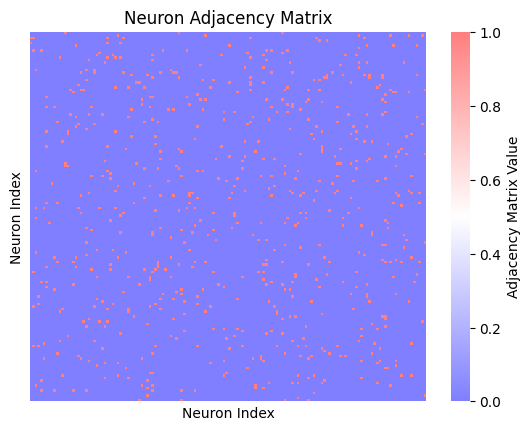



Network Configuration:


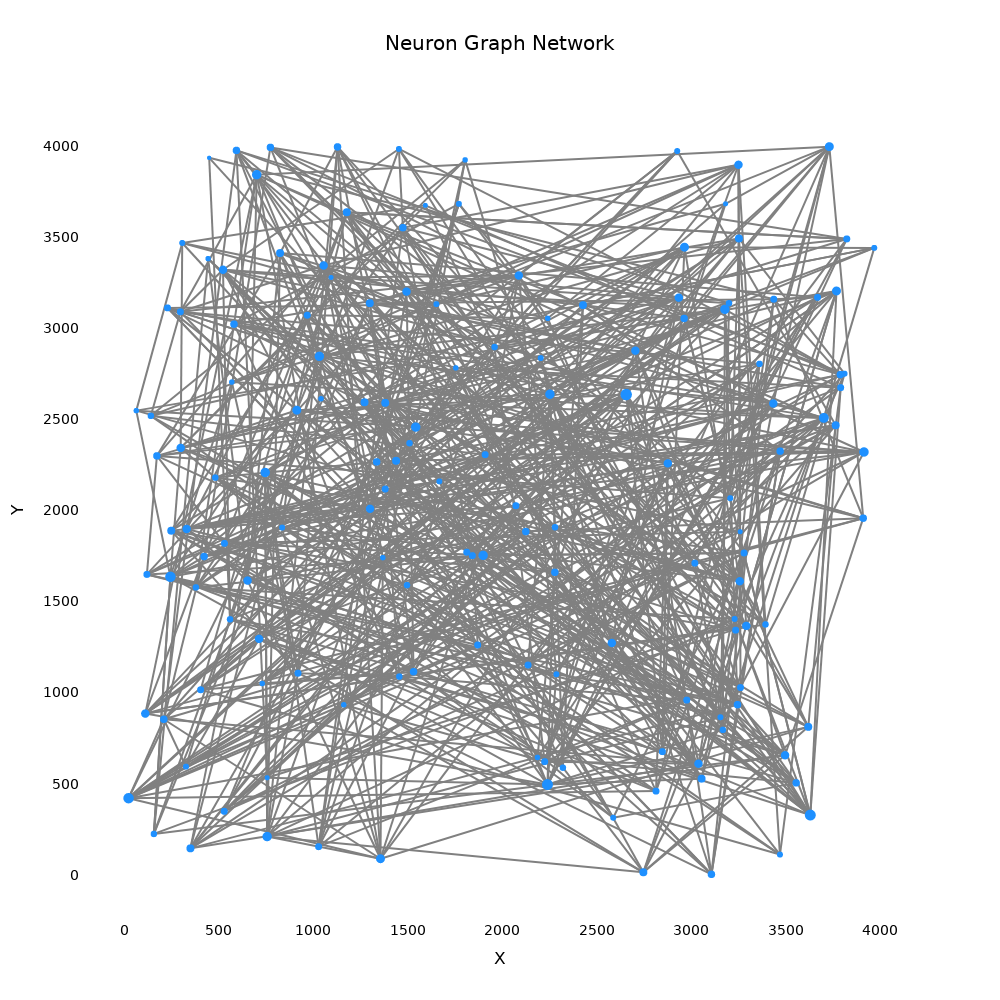

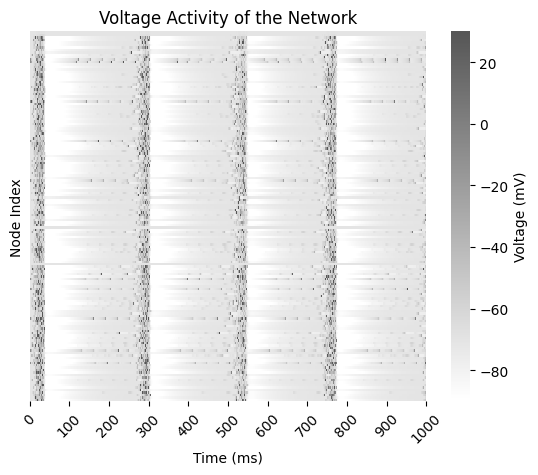

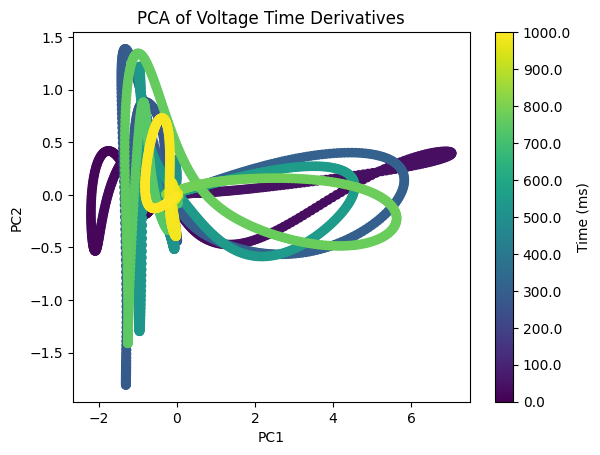

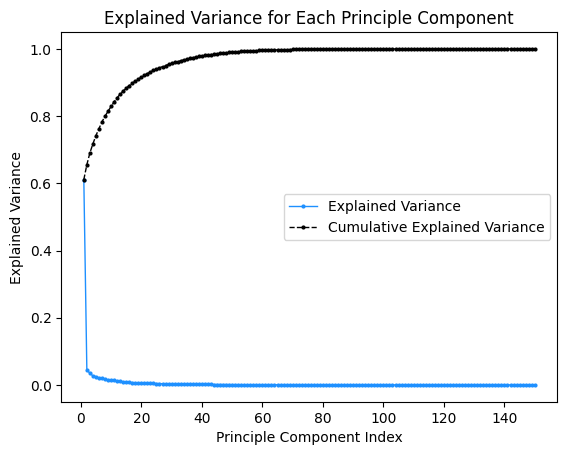

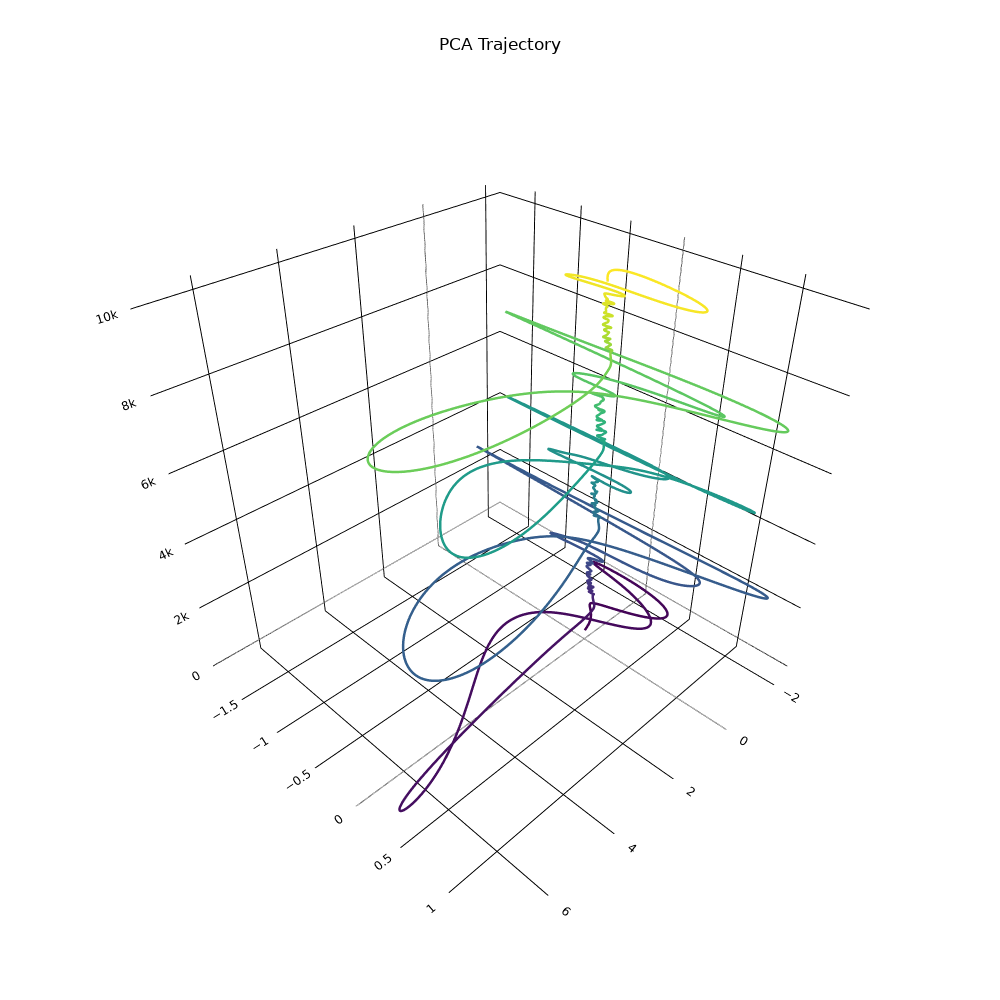

In [3]:
# Define an array ID so that I can save the data under this concept
array_id = 1
n = config_dict['general']['n'] # Number of neurons to have in the randomized network

# If we want to have injected current constantly stimulating values instead of / with random external activity
# constant_injected_current_index = None
num_time_steps_with_injection = None
# constant_injected_current_index = np.array([0])
np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons

# Booleans to control what's happening
implement_nueron_modules_positions = False # We want to test without modules right now
implement_neuron_modules_connections = False # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = False # This will be tested later
implement_constant_weights = False # Weights will be drawn from a normal distribution
vary_neuron_type = False # Keep all neurons as the same

# Image path incorporating the array id
adjacency_matrix_path = base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = base_path + f'network-graph-{array_id}.png'
spike_trace_path = base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = base_path + f'voltage-trace-{array_id}.png'
pca_save_path = base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = base_path + f'explained-variance-plot-{array_id}.png'

out, NetworkTuple = FullSimulation(
    config_dict = config_dict,
    array_id = array_id,
    seed = seed, 
    n = n,
    n_per_group = n_per_group, # This won't actually matter here because not implementing modules
    n_dim = n_dim,
    radius = radius,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    module_std = module_std,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    q = q, # This matters for now because we're using randomized activity
    injected_current_decay_parameter = injected_current_decay_parameter,
    include_constant_injected_current_to_rich_club = include_constant_injected_current_to_rich_club,
    x1_mean = x1_mean, 
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    check_distance_matrix_symmetry = check_distance_matrix_symmetry,
    visualize_adjacency_matrix= visualize_adjacency_matrix,
    adjacency_matrix_path = adjacency_matrix_path,
    visualize_connected_network= visualize_connected_network,
    network_graph_path = network_graph_path,
    num_time_steps = num_time_steps,
    t_step_size = t_step_size,
    save_outputs = save_outputs,
    implement_timing = implement_timing,
    implement_constant_weights = implement_constant_weights,
    vary_neuron_type = vary_neuron_type,
    diagnostic_printing = diagnostic_printing,
    resting_voltage = resting_voltage,
    default_a = default_a,
    default_b = default_b,
    default_c = default_c,
    default_d = default_d,
    highest_injected_current = highest_injected_current,
    num_groups = num_groups,
    number_of_rich_club_neurons_to_stimulate = number_of_rich_club_neurons_to_stimulate,
    constant_weight_value = constant_weight_value,
    visualize_spike_trace = visualize_spike_trace,
    spike_trace_path = spike_trace_path,
    visualize_voltage_trace = visualize_voltage_trace,
    voltage_trace_path = voltage_trace_path,
    constant_injected_current_index = constant_injected_current_index,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    constant_connection_probability = constant_connection_probability, # We care about distance for now
    num_time_steps_with_injection = num_time_steps_with_injection,
    superthreshold_injected_current = superthreshold_injected_current
)

# Plot the results in lower dimension
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma)
PlotPCA(out, x_reduced, file_save_path = pca_save_path)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, num_time_steps, save_filepath = pca_trajectory_path)

##### Random Network Placement and Connection Distance Matters

Network Density: 2.59%
Adjacency Matrix:


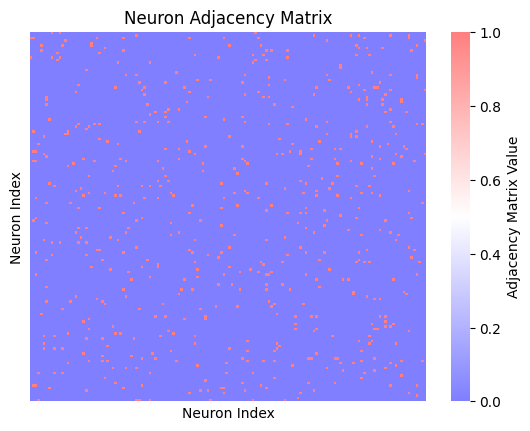



Network Configuration:


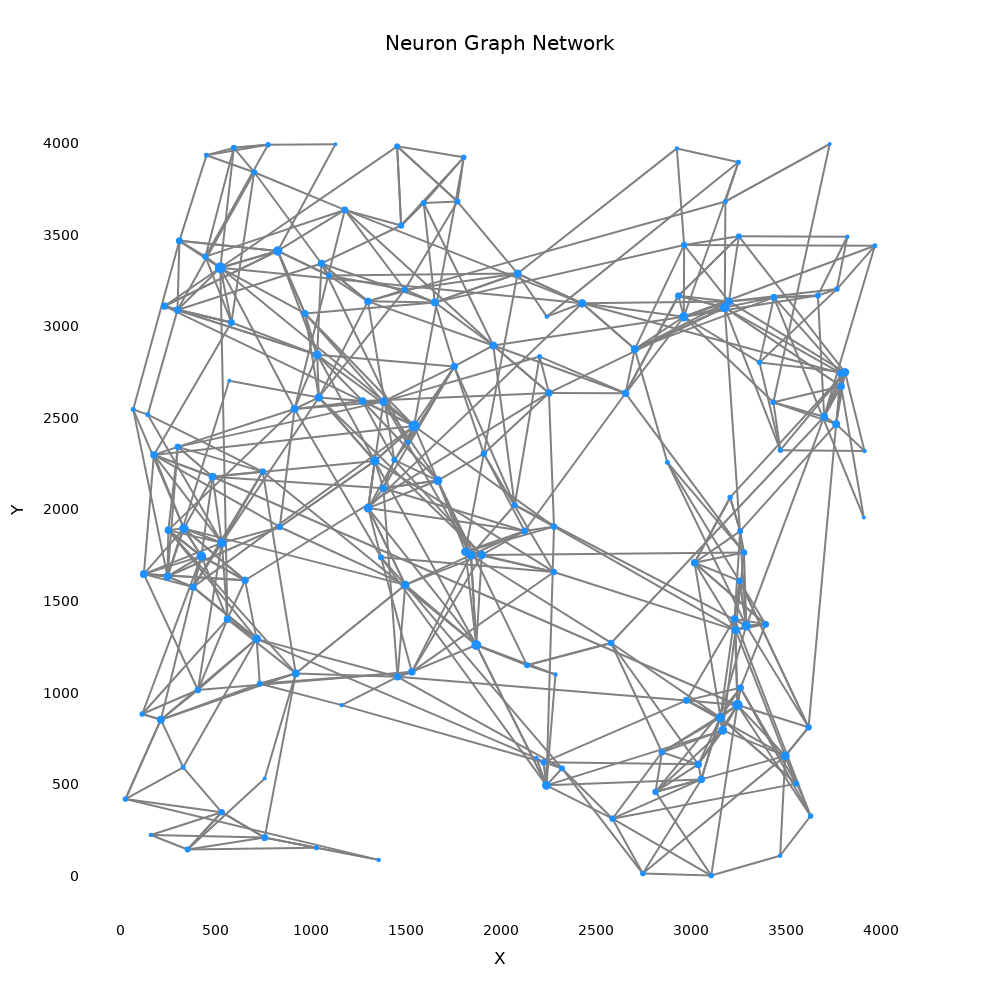

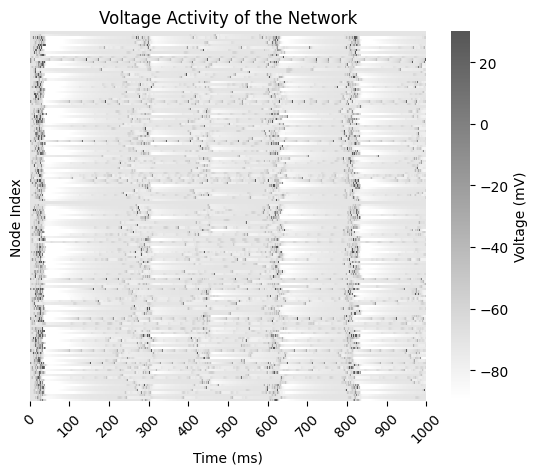

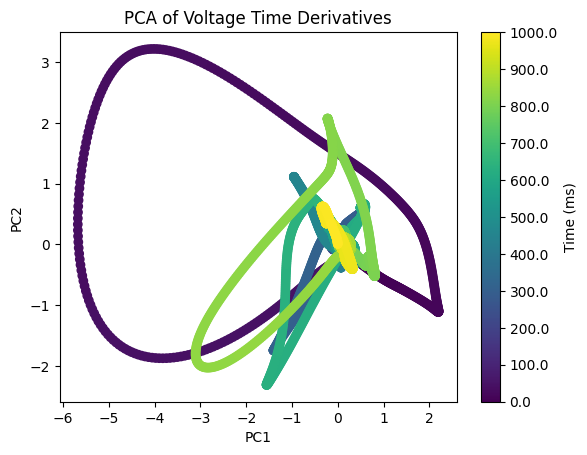

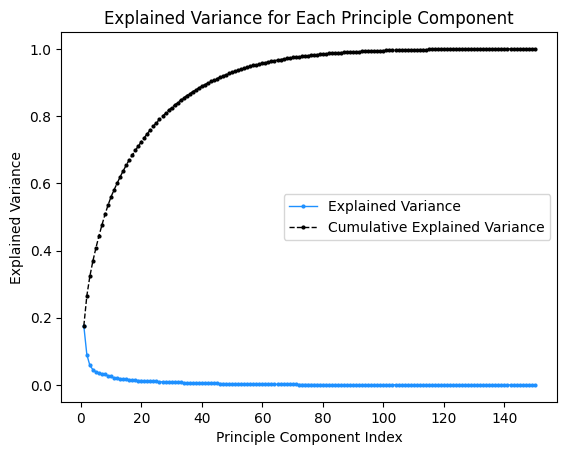

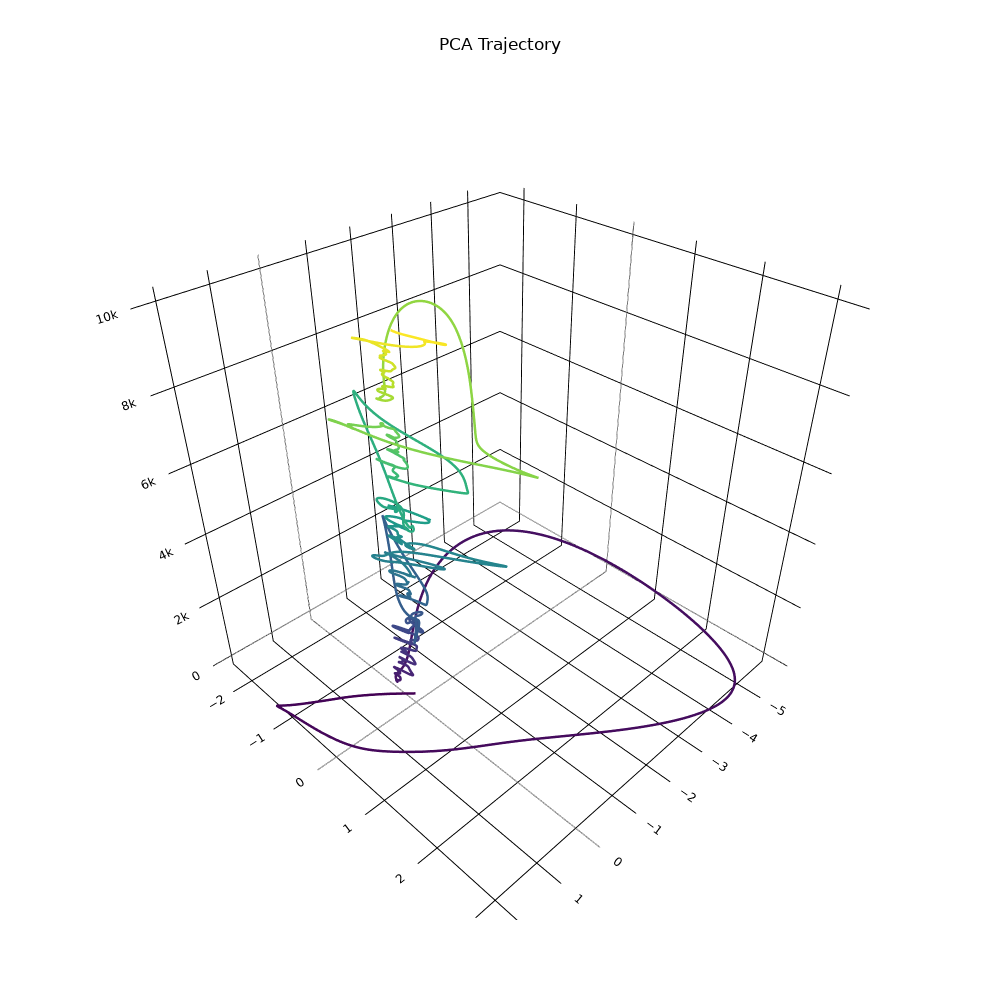

In [4]:
# Define an array ID so that I can save the data under this concept
array_id = 2
n = config_dict['general']['n'] # Number of neurons to have in the randomized network

# If we want to have injected current constantly stimulating values instead of / with random external activity
# constant_injected_current_index = None
# constant_injected_current_index = np.array([4]) # Constant stimulation to neuron index 1
# constant_injected_current_index = np.random.choice(np.arange(n), num_stimulated_neurons, replace = False) # Constant stimulation to a number of neurons
np.random.seed(seed)
constant_injected_current_index = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
) # Constant stimulation to a number of neurons


# Booleans to control what's happening
implement_nueron_modules_positions = False # We want to test without modules right now
implement_neuron_modules_connections = False # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity to selected axons
implement_timing = False # This will be tested later
implement_constant_weights = False # Weights will be drawn from a normal distribution
vary_neuron_type = False # Keep all neurons as the same
constant_connection_probability = None # We care about distance now, so remove constant_connection_probability

# Image path incorporating the array id
adjacency_matrix_path = base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = base_path + f'network-graph-{array_id}.png'
spike_trace_path = base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = base_path + f'voltage-trace-{array_id}.png'
pca_save_path = base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = base_path + f'explained-variance-plot-{array_id}.png'

out, NetworkTuple = FullSimulation(
    config_dict = config_dict,
    array_id = array_id,
    seed = seed, 
    n = n,
    n_per_group = n_per_group, # This won't actually matter here because not implementing modules
    n_dim = n_dim,
    radius = radius,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    module_std = module_std,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    q = q, # This matters for now because we're using randomized activity
    injected_current_decay_parameter = injected_current_decay_parameter,
    include_constant_injected_current_to_rich_club = include_constant_injected_current_to_rich_club,
    x1_mean = x1_mean, 
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    check_distance_matrix_symmetry = check_distance_matrix_symmetry,
    visualize_adjacency_matrix= visualize_adjacency_matrix,
    adjacency_matrix_path = adjacency_matrix_path,
    visualize_connected_network= visualize_connected_network,
    network_graph_path = network_graph_path,
    num_time_steps = num_time_steps,
    t_step_size = t_step_size,
    save_outputs = save_outputs,
    implement_timing = implement_timing,
    implement_constant_weights = implement_constant_weights,
    vary_neuron_type = vary_neuron_type,
    diagnostic_printing = diagnostic_printing,
    resting_voltage = resting_voltage,
    default_a = default_a,
    default_b = default_b,
    default_c = default_c,
    default_d = default_d,
    highest_injected_current = highest_injected_current,
    num_groups = num_groups,
    number_of_rich_club_neurons_to_stimulate = number_of_rich_club_neurons_to_stimulate,
    constant_weight_value = constant_weight_value,
    visualize_spike_trace = visualize_spike_trace,
    spike_trace_path = spike_trace_path,
    visualize_voltage_trace = visualize_voltage_trace,
    voltage_trace_path = voltage_trace_path,
    constant_injected_current_index = constant_injected_current_index,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    constant_connection_probability = constant_connection_probability,
    superthreshold_injected_current = superthreshold_injected_current
)

# Plot the results in lower dimension
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma)
PlotPCA(out, x_reduced, file_save_path = pca_save_path)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, num_time_steps, pca_trajectory_path)

##### Modules

For this implementation, I placed neurons in 3 different modules. Keeping the effect of distances on connection probabilities.

Network Density: 3.11%
Adjacency Matrix:


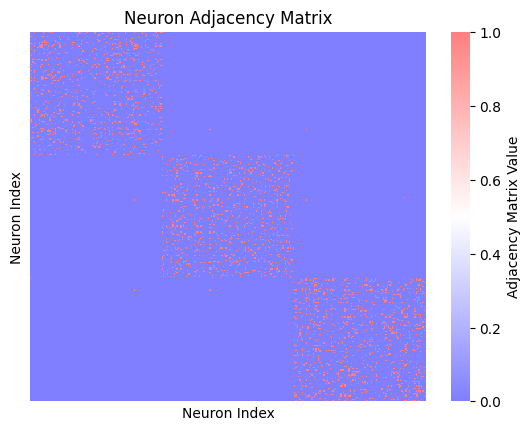



Network Configuration:


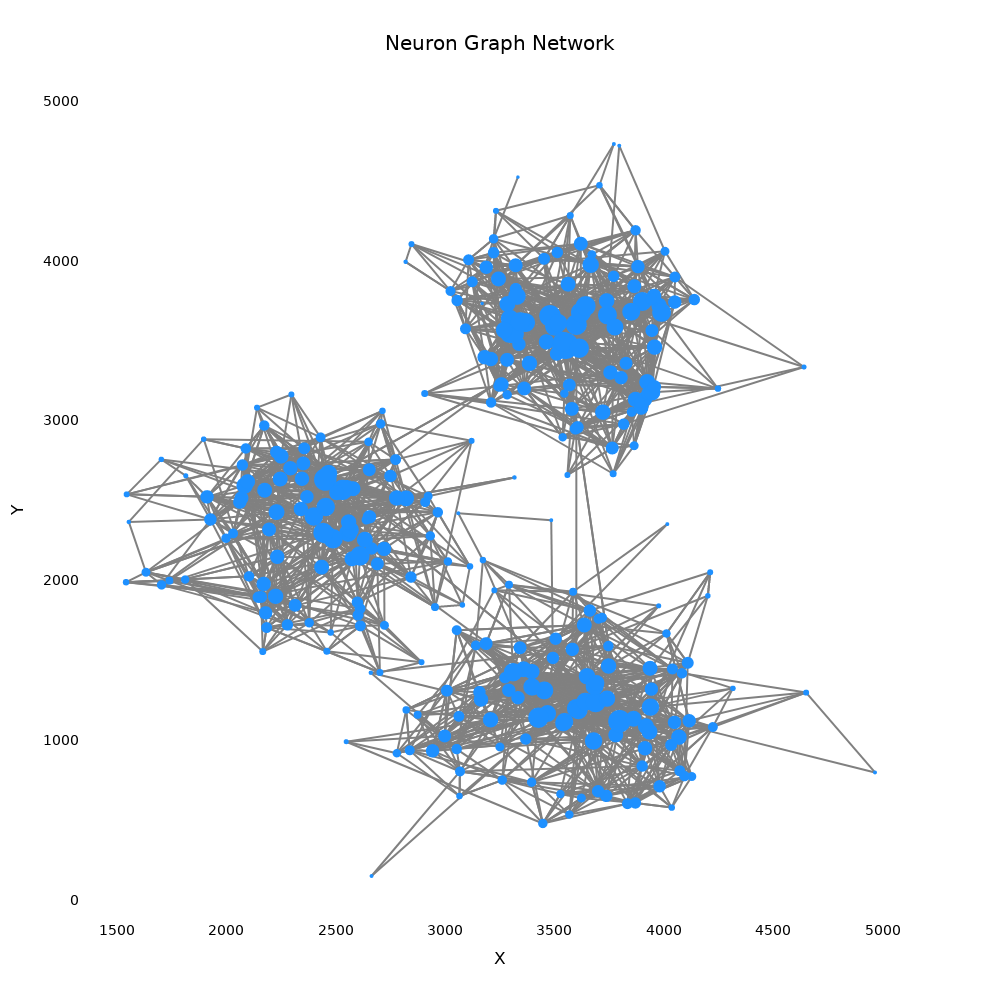

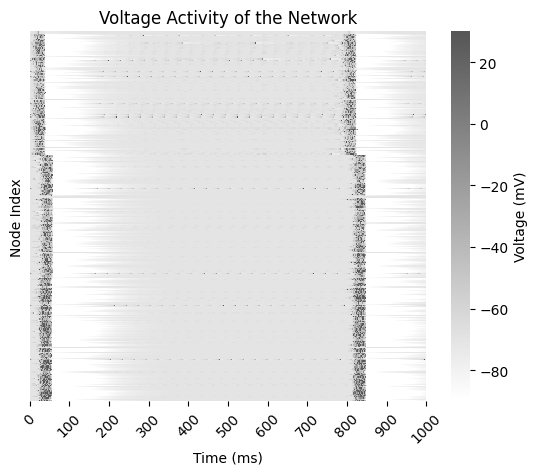

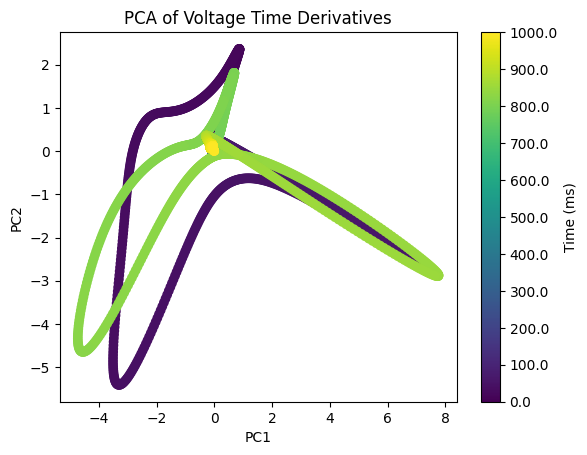

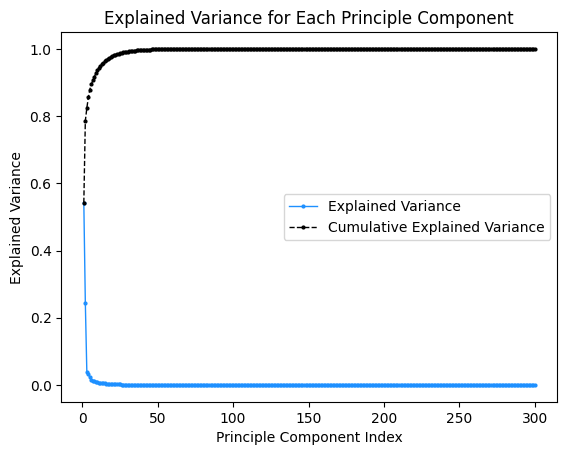

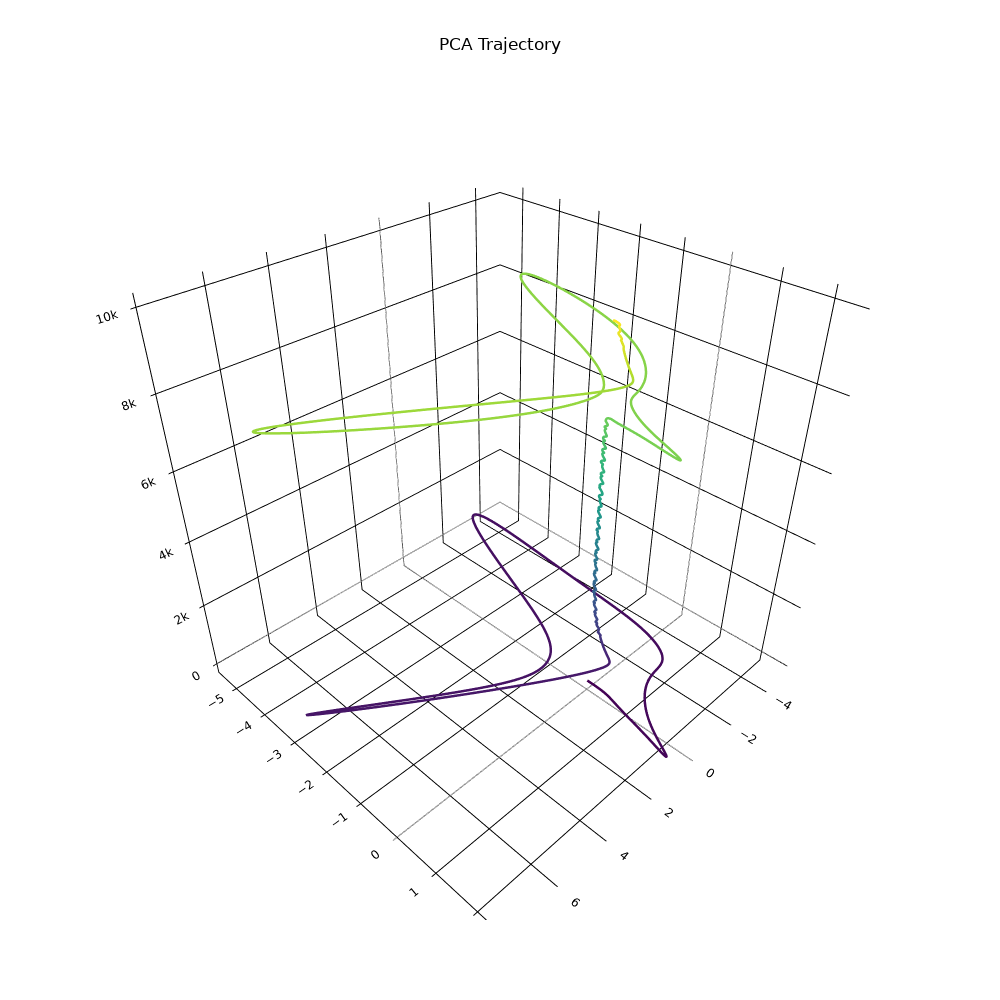

In [49]:
# Define an array ID so that I can save the data under this concept
array_id = 3
 
# Booleans to control what's happening
implement_nueron_modules_positions = True # We want to test with modules now
implement_neuron_modules_connections = True # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = False # Now we're intereseted in the effect of timing on the system
implement_constant_weights = False # Weights will be normally distributed
vary_neuron_type = False # Keep all neurons as the same
constant_connection_probability = None # We care about distance now, so remove constant_connection_probability

# Changes to work with modules and not have drastic results
distance_connection_probability_exponent_constant_for_modules = 28
highest_injected_current_for_modules = 7

# Image path incorporating the array id
adjacency_matrix_path = base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = base_path + f'network-graph-{array_id}.png'
spike_trace_path = base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = base_path + f'voltage-trace-{array_id}.png'
pca_save_path = base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = base_path + f'explained-variance-plot-{array_id}.png'

# constant_injected_current_index = np.array([19]) 
# np.random.seed(seed) # Set the seed so that the same neurons are stimulated each time, at least now when the positions will be the same
constant_injected_current_index = np.random.choice(
    np.arange(n_per_group * num_groups),
    num_neurons_to_stimluate, 
    replace = False
)
# constant_injected_current_index = np.array([0]) # Stimulate module 1

out, NetworkTuple = FullSimulation(
    config_dict = config_dict,
    array_id = array_id,
    seed = seed, # Setting seed to None because I want to use the seed from the top of the script rather than setting the seed everytime
    n = n,
    n_per_group = n_per_group, # This won't actually matter here because not implementing modules
    n_dim = n_dim,
    radius = radius,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    module_std = module_std,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant_for_modules, # Changing the connection probabilities for this one so that it is not so dense
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    q = q, # This matters for now because we're using randomized activity
    injected_current_decay_parameter = injected_current_decay_parameter,
    include_constant_injected_current_to_rich_club = include_constant_injected_current_to_rich_club,
    x1_mean = x1_mean, 
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    check_distance_matrix_symmetry = check_distance_matrix_symmetry,
    visualize_adjacency_matrix= visualize_adjacency_matrix,
    adjacency_matrix_path = adjacency_matrix_path,
    visualize_connected_network= visualize_connected_network,
    network_graph_path = network_graph_path,
    num_time_steps = num_time_steps,
    t_step_size = t_step_size,
    save_outputs = save_outputs,
    implement_timing = implement_timing,
    implement_constant_weights = implement_constant_weights,
    vary_neuron_type = vary_neuron_type,
    diagnostic_printing = diagnostic_printing,
    resting_voltage = resting_voltage,
    default_a = default_a,
    default_b = default_b,
    default_c = default_c,
    default_d = default_d,
    highest_injected_current = highest_injected_current_for_modules, # Changing the maximum injected current value so that it's not too large
    num_groups = num_groups,
    number_of_rich_club_neurons_to_stimulate = number_of_rich_club_neurons_to_stimulate,
    constant_weight_value = constant_weight_value,
    visualize_spike_trace = visualize_spike_trace,
    spike_trace_path = spike_trace_path,
    visualize_voltage_trace = visualize_voltage_trace,
    voltage_trace_path = voltage_trace_path,
    constant_injected_current_index = constant_injected_current_index,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    constant_connection_probability = constant_connection_probability,
    num_time_steps_with_injection = num_time_steps_with_injection,
    superthreshold_injected_current = superthreshold_injected_current
)

# Plot the results in lower dimension
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma)
PlotPCA(out, x_reduced, file_save_path = pca_save_path)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, num_time_steps, pca_trajectory_path)

### Implemented Timing

##### Fixed Diameter without Modules

Network Density: 2.59%
Adjacency Matrix:


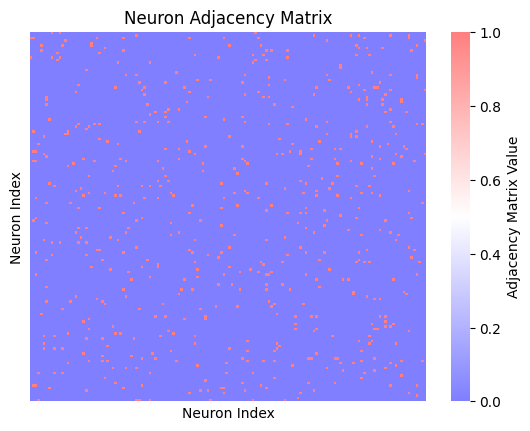



Network Configuration:


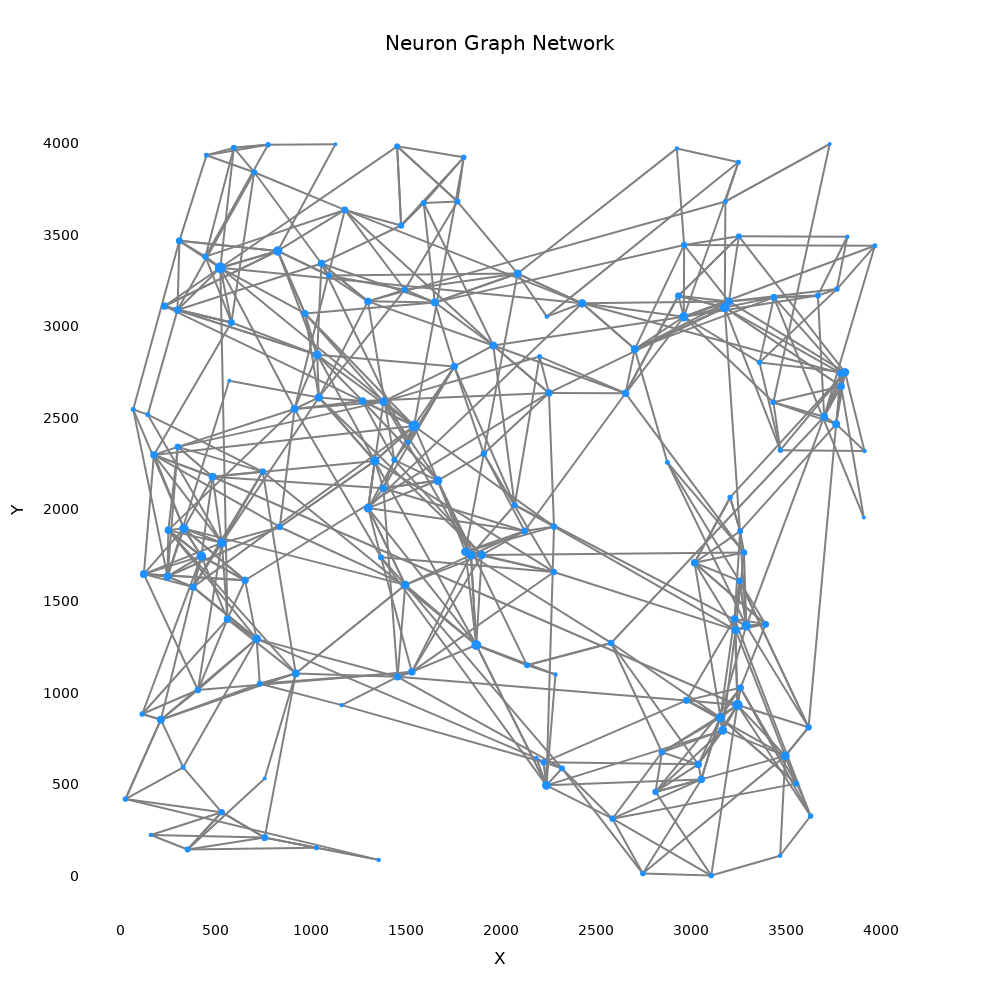

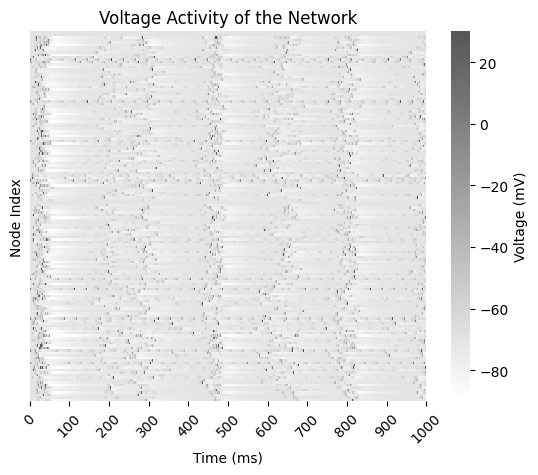

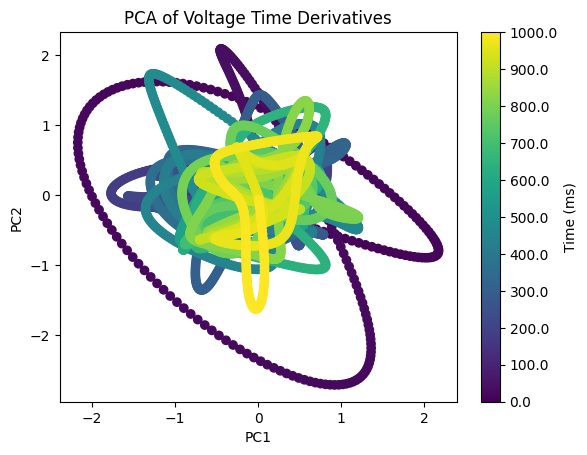

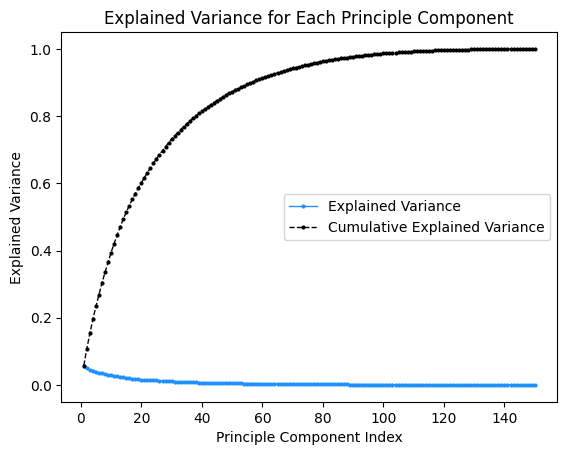

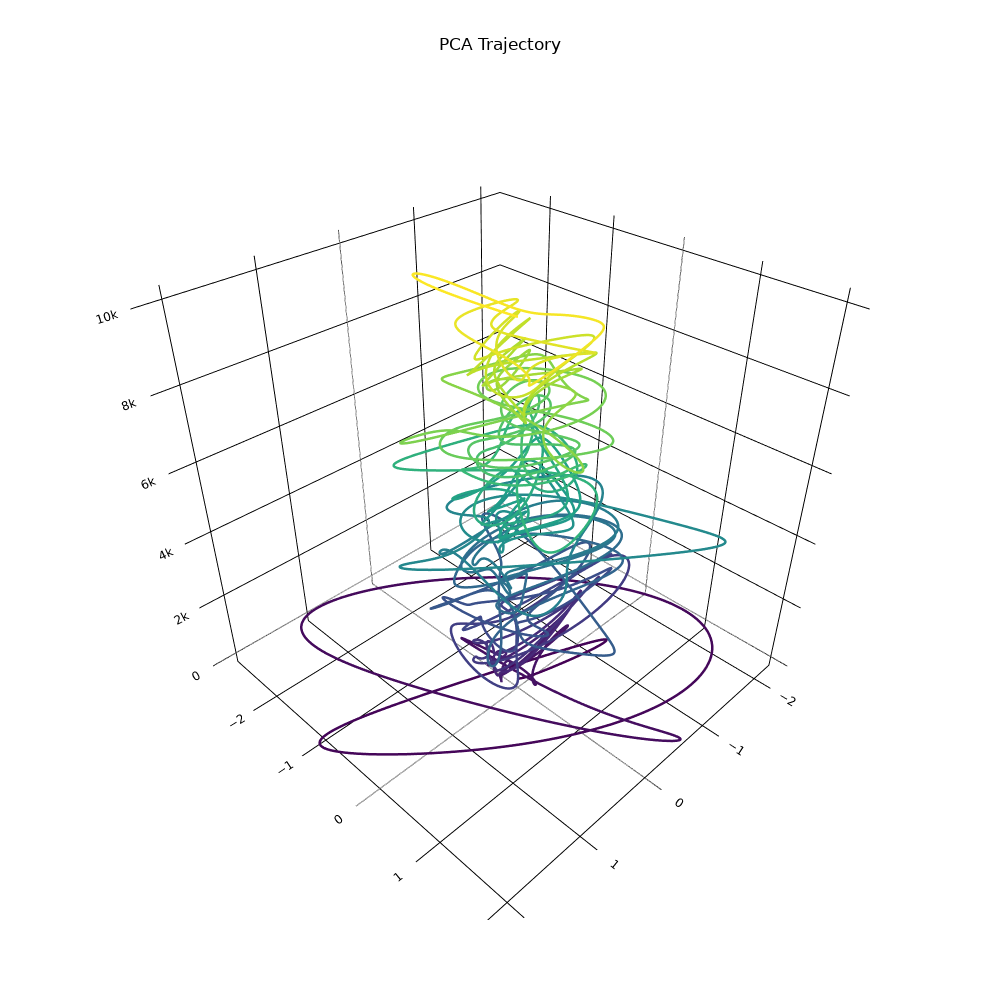

In [51]:
# Define an array ID so that I can save the data under this concept
array_id = 4

# Booleans to control what's happening
implement_nueron_modules_positions = False # Starting without modules for now
implement_neuron_modules_connections = False # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = True # No we want to identify effects based on differences in timing
implement_constant_weights = False # Weights will be normally distributed
vary_neuron_type = False # Keep all neurons as the same
constant_connection_probability = None # We care about distance now, so remove constant_connection_probability
constant_diameter = True # We want to keep a constant diameter

# Image path incorporating the array id
adjacency_matrix_path = base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = base_path + f'network-graph-{array_id}.png'
spike_trace_path = base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = base_path + f'voltage-trace-{array_id}.png'
pca_save_path = base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = base_path + f'explained-variance-plot-{array_id}.png'

np.random.seed(seed) # Set the seed so that the same neurons are stimulated each time, at least now when the positions will be the same
constant_injected_current_index  = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
)

# constant_injected_current_index = np.array([0]) # Allow signal to flow from module 0 to 1 and so on
out, NetworkTuple = FullSimulation(
    config_dict = config_dict,
    array_id = array_id,
    seed = seed, # Setting seed to None because I want to use the seed from the top of the script rather than setting the seed everytime
    n = n,
    n_per_group = n_per_group, # This won't actually matter here because not implementing modules
    n_dim = n_dim,
    radius = radius,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    module_std = module_std,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    q = q, # This matters for now because we're using randomized activity
    injected_current_decay_parameter = injected_current_decay_parameter,
    include_constant_injected_current_to_rich_club = include_constant_injected_current_to_rich_club,
    x1_mean = x1_mean, 
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    check_distance_matrix_symmetry = check_distance_matrix_symmetry,
    visualize_adjacency_matrix= visualize_adjacency_matrix,
    adjacency_matrix_path = adjacency_matrix_path,
    visualize_connected_network= visualize_connected_network,
    network_graph_path = network_graph_path,
    num_time_steps = num_time_steps,
    t_step_size = t_step_size,
    save_outputs = save_outputs,
    implement_timing = implement_timing,
    implement_constant_weights = implement_constant_weights,
    vary_neuron_type = vary_neuron_type,
    diagnostic_printing = diagnostic_printing,
    resting_voltage = resting_voltage,
    default_a = default_a,
    default_b = default_b,
    default_c = default_c,
    default_d = default_d,
    highest_injected_current = highest_injected_current,
    num_groups = num_groups,
    number_of_rich_club_neurons_to_stimulate = number_of_rich_club_neurons_to_stimulate,
    constant_weight_value = constant_weight_value,
    visualize_spike_trace = visualize_spike_trace,
    spike_trace_path = spike_trace_path,
    visualize_voltage_trace = visualize_voltage_trace,
    voltage_trace_path = voltage_trace_path,
    constant_injected_current_index = constant_injected_current_index,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    constant_connection_probability = constant_connection_probability,
    num_time_steps_with_injection = num_time_steps_with_injection,
    superthreshold_injected_current = superthreshold_injected_current,
    constant_diameter = constant_diameter
)

# Plot the results in lower dimension
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma)
PlotPCA(out, x_reduced, file_save_path = pca_save_path)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, num_time_steps, pca_trajectory_path)

##### Fixed diameter with modules

Network Density: 3.11%
Adjacency Matrix:


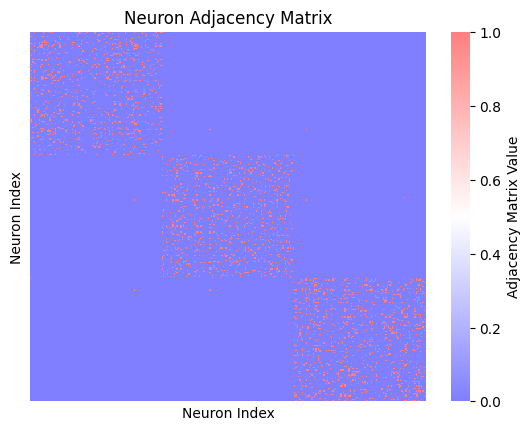



Network Configuration:


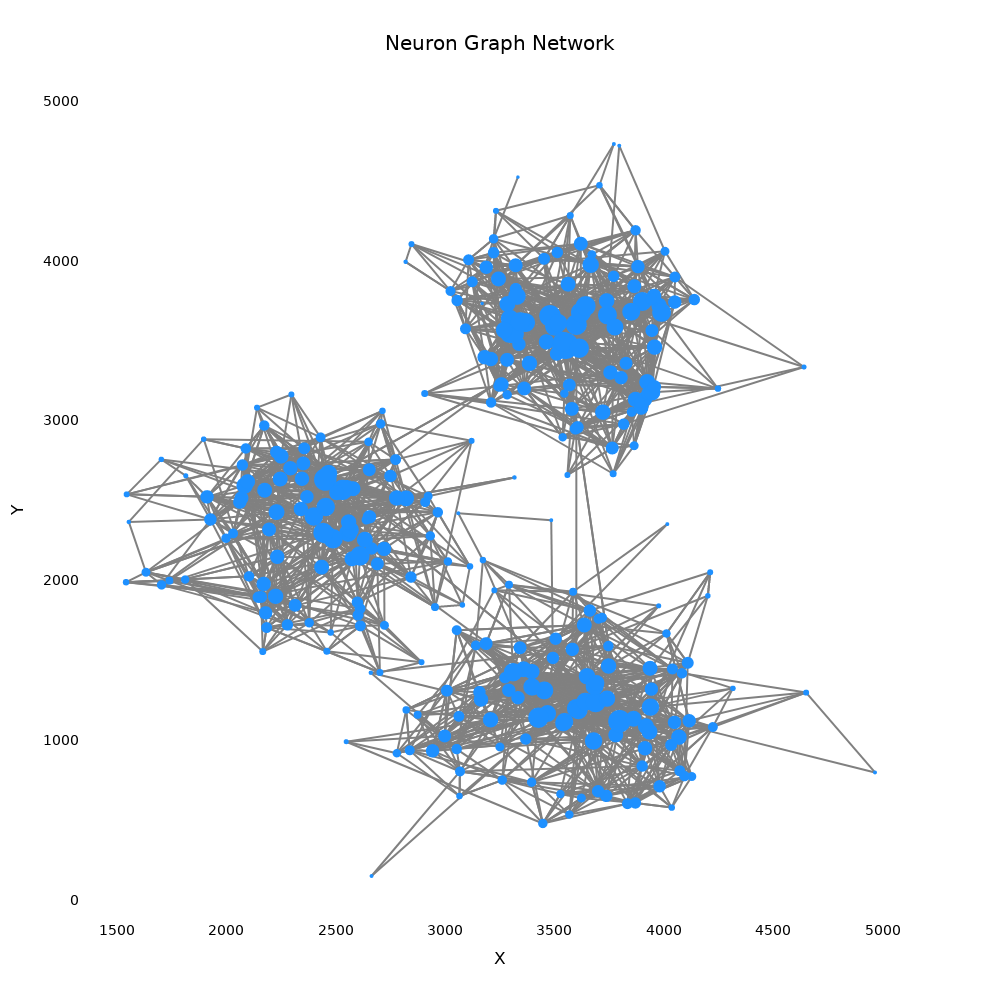

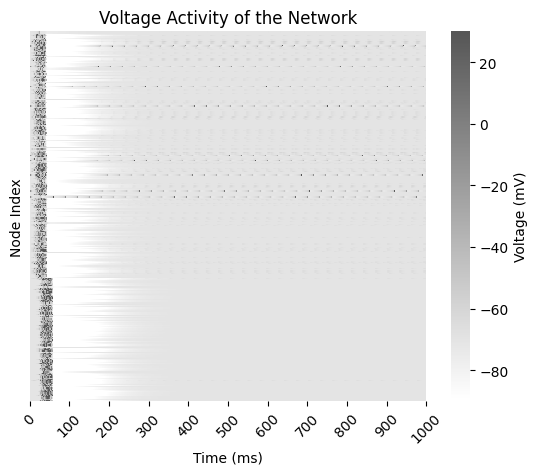

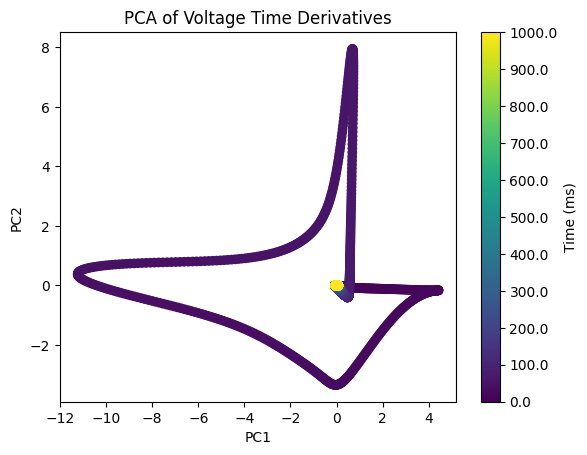

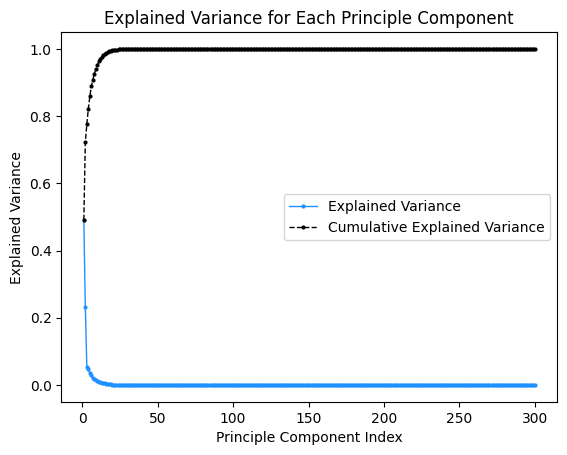

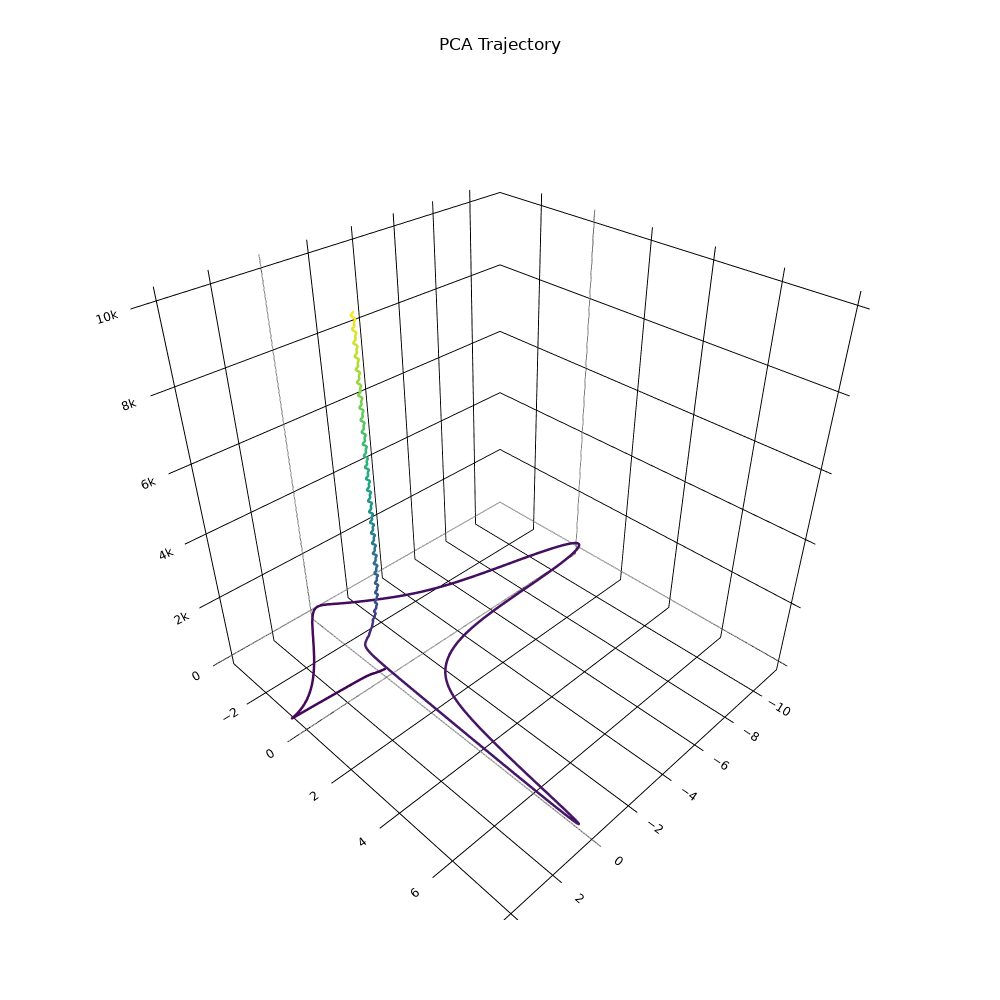

In [53]:
# Define an array ID so that I can save the data under this concept
array_id = 5

# Booleans to control what's happening
implement_nueron_modules_positions = True # We want to test with modules now
implement_neuron_modules_connections = True # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = False # This will be tested later
implement_constant_weights = False # Weights will be normally distributed
vary_neuron_type = False # Keep all neurons as the same
constant_connection_probability = None # We care about distance now, so remove constant_connection_probability
constant_diameter = True # Want to see the effects of keeping diameter constant and only varying axon length

# Make changes to match with modules design
distance_connection_probability_exponent_constant_for_modules = 28
highest_injected_current_for_modules = 7

# Image path incorporating the array id
adjacency_matrix_path = base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = base_path + f'network-graph-{array_id}.png'
spike_trace_path = base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = base_path + f'voltage-trace-{array_id}.png'
pca_save_path = base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = base_path + f'explained-variance-plot-{array_id}.png'

# np.random.seed(seed) # Set the seed so that the same neurons are stimulated each time, at least now when the positions will be the same
np.random.seed(seed) # Set the seed so that the same neurons are stimulated each time, at least now when the positions will be the same
constant_injected_current_index  = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
)

out, NetworkTuple = FullSimulation(
    config_dict = config_dict,
    array_id = array_id,
    seed = seed, # Setting seed to None because I want to use the seed from the top of the script rather than setting the seed everytime
    n = n,
    n_per_group = n_per_group, # This won't actually matter here because not implementing modules
    n_dim = n_dim,
    radius = radius,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    module_std = module_std,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant_for_modules,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    q = q, # This matters for now because we're using randomized activity
    injected_current_decay_parameter = injected_current_decay_parameter,
    include_constant_injected_current_to_rich_club = include_constant_injected_current_to_rich_club,
    x1_mean = x1_mean, 
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    check_distance_matrix_symmetry = check_distance_matrix_symmetry,
    visualize_adjacency_matrix= visualize_adjacency_matrix,
    adjacency_matrix_path = adjacency_matrix_path,
    visualize_connected_network= visualize_connected_network,
    network_graph_path = network_graph_path,
    num_time_steps = num_time_steps,
    t_step_size = t_step_size,
    save_outputs = save_outputs,
    implement_timing = implement_timing,
    implement_constant_weights = implement_constant_weights,
    vary_neuron_type = vary_neuron_type,
    diagnostic_printing = diagnostic_printing,
    resting_voltage = resting_voltage,
    default_a = default_a,
    default_b = default_b,
    default_c = default_c,
    default_d = default_d,
    highest_injected_current = highest_injected_current_for_modules,
    num_groups = num_groups,
    number_of_rich_club_neurons_to_stimulate = number_of_rich_club_neurons_to_stimulate,
    constant_weight_value = constant_weight_value,
    visualize_spike_trace = visualize_spike_trace,
    spike_trace_path = spike_trace_path,
    visualize_voltage_trace = visualize_voltage_trace,
    voltage_trace_path = voltage_trace_path,
    constant_injected_current_index = constant_injected_current_index,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    constant_connection_probability = constant_connection_probability,
    num_time_steps_with_injection = num_time_steps_with_injection,
    constant_diameter = constant_diameter,
    superthreshold_injected_current = superthreshold_injected_current
)

# Plot the results in lower dimension
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma)
PlotPCA(out, x_reduced, file_save_path = pca_save_path)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, num_time_steps, pca_trajectory_path)

##### Varying Diameter without Modules

Network Density: 2.59%
Adjacency Matrix:


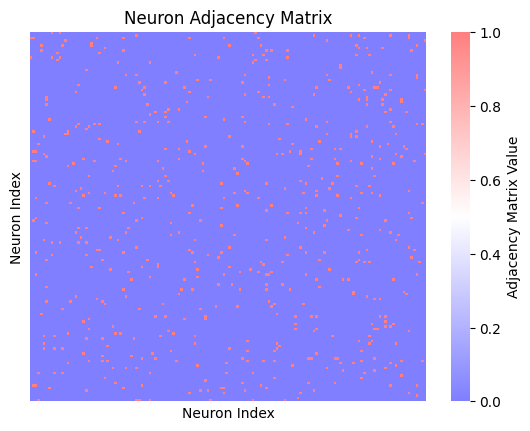



Network Configuration:


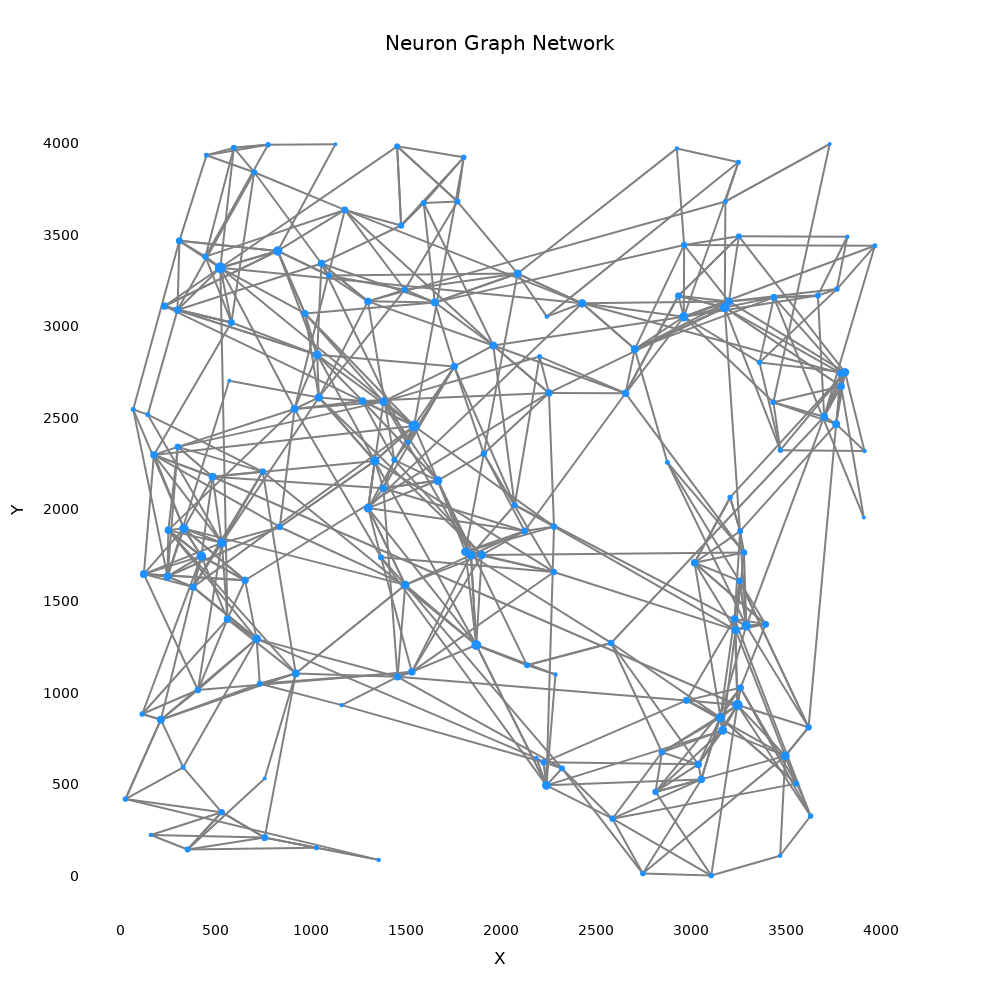

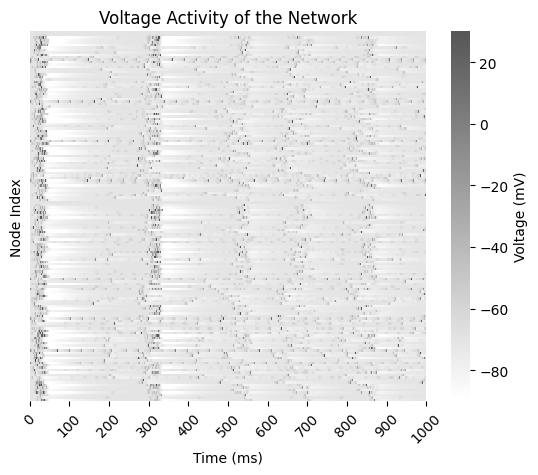

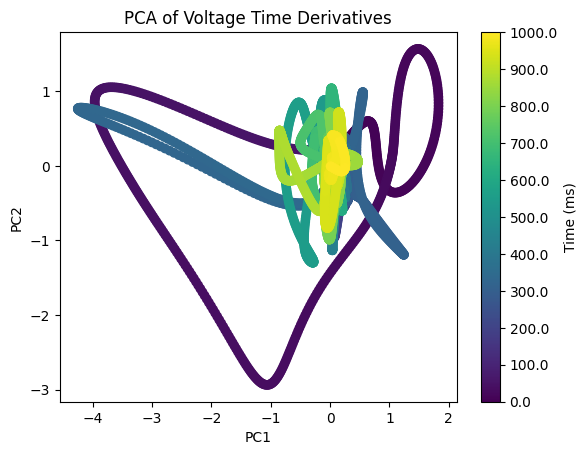

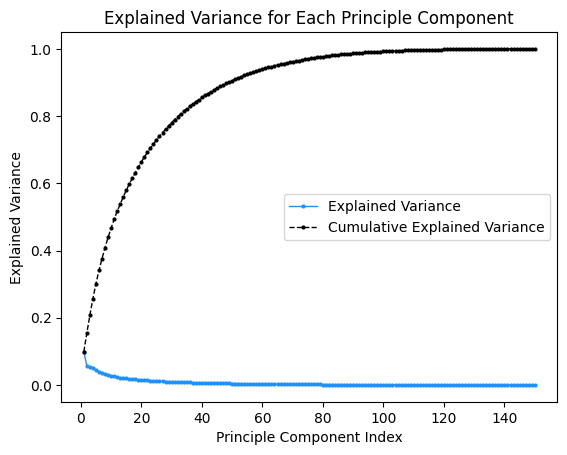

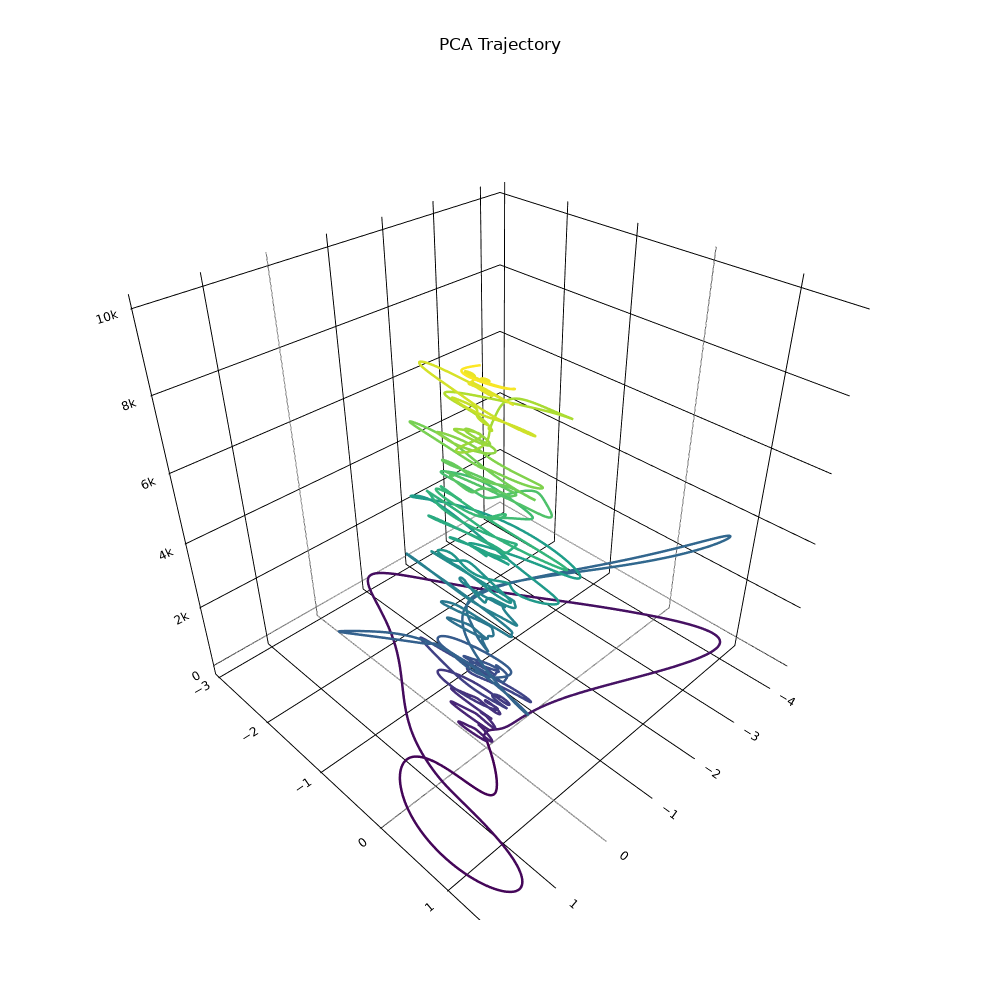

In [54]:
# Define an array ID so that I can save the data under this concept
array_id = 6
n = config_dict['general']['n']

# Booleans to control what's happening
implement_nueron_modules_positions = False # We want to test with modules now
implement_neuron_modules_connections = False # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = True # This will be tested later
implement_constant_weights = False # Weights will be normally distributed
vary_neuron_type = False # Keep all neurons as the same
constant_connection_probability = None # We care about distance now, so remove constant_connection_probability
constant_diameter = False # We want to vary the diameter size now

# Image path incorporating the array id
adjacency_matrix_path = base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = base_path + f'network-graph-{array_id}.png'
spike_trace_path = base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = base_path + f'voltage-trace-{array_id}.png'
pca_save_path = base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = base_path + f'explained-variance-plot-{array_id}.png'

np.random.seed(seed) # Set the seed so that the same neurons are stimulated each time, at least now when the positions will be the same
constant_injected_current_index  = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
)
     
out, NetworkTuple = FullSimulation(
    config_dict = config_dict,
    array_id = array_id,
    seed = seed, # Setting seed to None because I want to use the seed from the top of the script rather than setting the seed everytime
    n = n,
    n_per_group = n_per_group, # This won't actually matter here because not implementing modules
    n_dim = n_dim,
    radius = radius,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    module_std = module_std,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    q = q, # This matters for now because we're using randomized activity
    injected_current_decay_parameter = injected_current_decay_parameter,
    include_constant_injected_current_to_rich_club = include_constant_injected_current_to_rich_club,
    x1_mean = x1_mean, 
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    check_distance_matrix_symmetry = check_distance_matrix_symmetry,
    visualize_adjacency_matrix= visualize_adjacency_matrix,
    adjacency_matrix_path = adjacency_matrix_path,
    visualize_connected_network= visualize_connected_network,
    network_graph_path = network_graph_path,
    num_time_steps = num_time_steps,
    t_step_size = t_step_size,
    save_outputs = save_outputs,
    implement_timing = implement_timing,
    implement_constant_weights = implement_constant_weights,
    vary_neuron_type = vary_neuron_type,
    diagnostic_printing = diagnostic_printing,
    resting_voltage = resting_voltage,
    default_a = default_a,
    default_b = default_b,
    default_c = default_c,
    default_d = default_d,
    highest_injected_current = highest_injected_current,
    num_groups = num_groups,
    number_of_rich_club_neurons_to_stimulate = number_of_rich_club_neurons_to_stimulate,
    constant_weight_value = constant_weight_value,
    visualize_spike_trace = visualize_spike_trace,
    spike_trace_path = spike_trace_path,
    visualize_voltage_trace = visualize_voltage_trace,
    voltage_trace_path = voltage_trace_path,
    constant_injected_current_index = constant_injected_current_index,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    constant_connection_probability = constant_connection_probability,
    num_time_steps_with_injection = num_time_steps_with_injection,
    superthreshold_injected_current = superthreshold_injected_current
)

# Plot the results in lower dimension
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma)
PlotPCA(out, x_reduced, file_save_path = pca_save_path)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, num_time_steps, pca_trajectory_path)

##### Varying Diameter with Modules

Network Density: 3.11%
Adjacency Matrix:


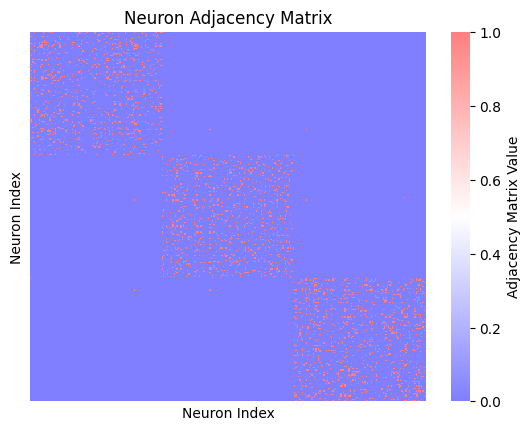



Network Configuration:


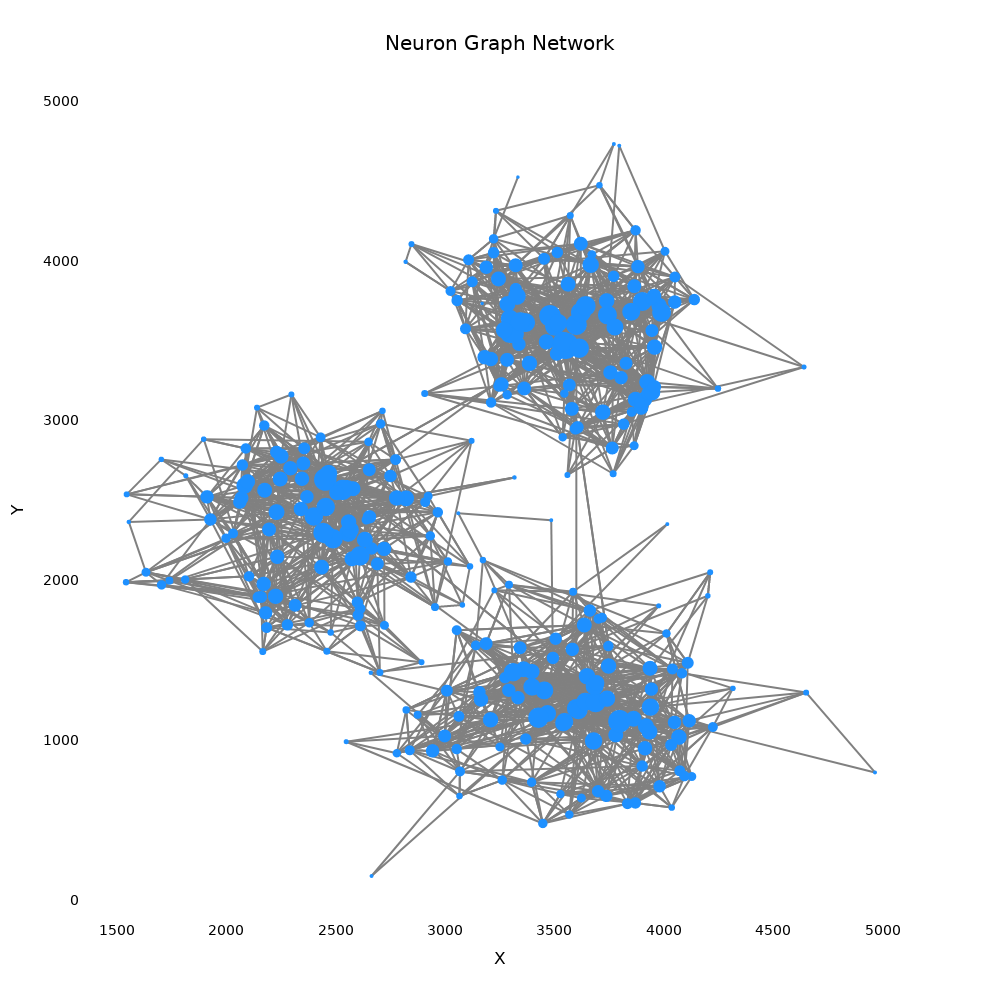

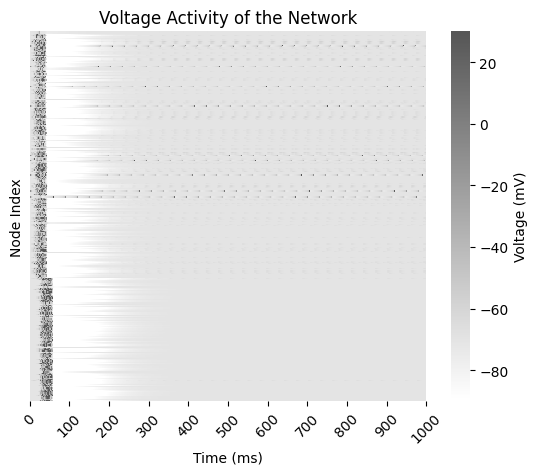

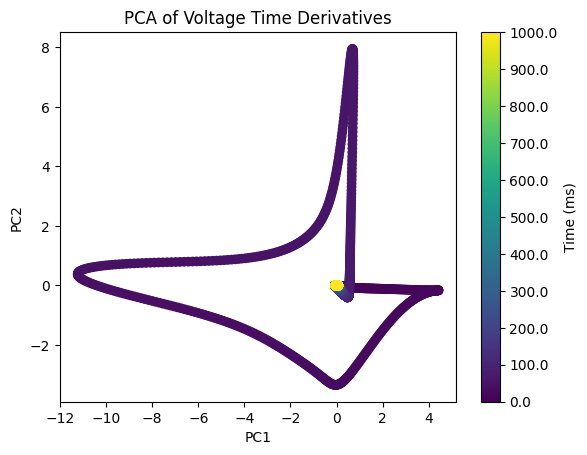

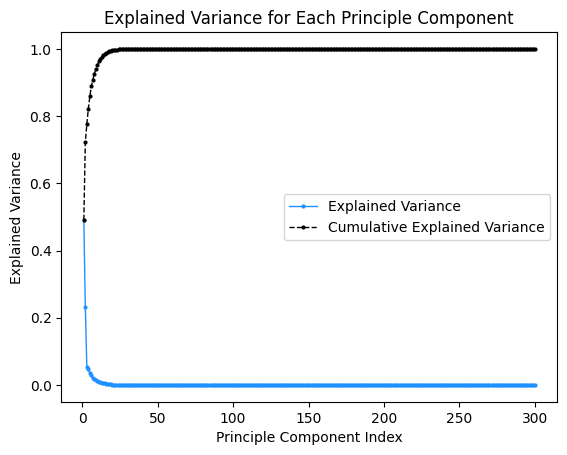

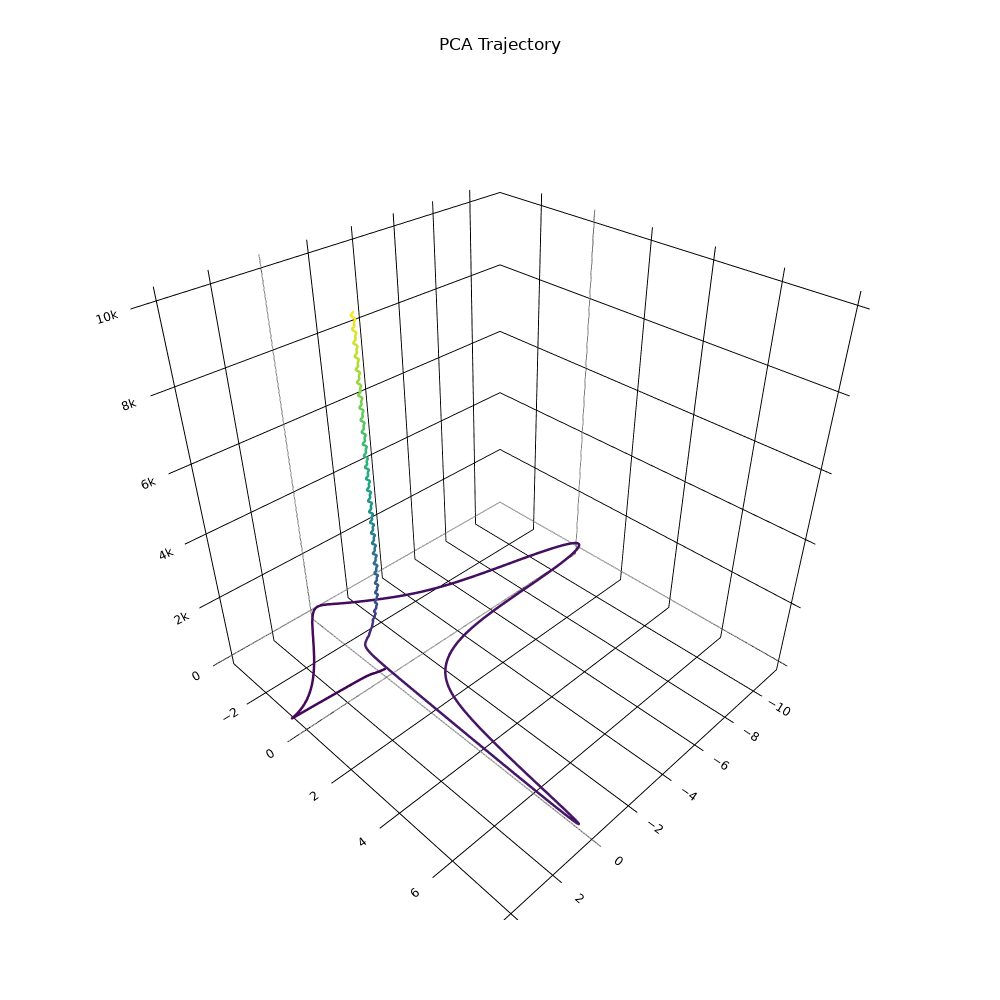

In [55]:
# Define an array ID so that I can save the data under this concept
array_id = 7

# Booleans to control what's happening
implement_nueron_modules_positions = True # We want to test with modules now
implement_neuron_modules_connections = True # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = False # This will be tested later
implement_constant_weights = False # Weights will be normally distributed
vary_neuron_type = False # Keep all neurons as the same
constant_connection_probability = None # We care about distance now, so remove constant_connection_probability
constant_diameter = False # Want to see the effects of keeping diameter constant and only varying axon length

# Make changes to match with modules design
distance_connection_probability_exponent_constant_for_modules = 28
highest_injected_current_for_modules = 7

# Image path incorporating the array id
adjacency_matrix_path = base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = base_path + f'network-graph-{array_id}.png'
spike_trace_path = base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = base_path + f'voltage-trace-{array_id}.png'
pca_save_path = base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = base_path + f'explained-variance-plot-{array_id}.png'

# np.random.seed(seed) # Set the seed so that the same neurons are stimulated each time, at least now when the positions will be the same
np.random.seed(seed) # Set the seed so that the same neurons are stimulated each time, at least now when the positions will be the same
constant_injected_current_index  = np.random.choice(
    np.arange(n), num_neurons_to_stimluate, 
    replace = False
)

out, NetworkTuple = FullSimulation(
    config_dict = config_dict,
    array_id = array_id,
    seed = seed, # Setting seed to None because I want to use the seed from the top of the script rather than setting the seed everytime
    n = n,
    n_per_group = n_per_group, # This won't actually matter here because not implementing modules
    n_dim = n_dim,
    radius = radius,
    implement_nueron_modules_positions = implement_nueron_modules_positions,
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    module_std = module_std,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant_for_modules,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    q = q, # This matters for now because we're using randomized activity
    injected_current_decay_parameter = injected_current_decay_parameter,
    include_constant_injected_current_to_rich_club = include_constant_injected_current_to_rich_club,
    x1_mean = x1_mean, 
    x2_mean = x2_mean,
    x3_mean = x3_mean,
    y1_mean = y1_mean,
    y2_mean = y2_mean,
    y3_mean = y3_mean,
    check_distance_matrix_symmetry = check_distance_matrix_symmetry,
    visualize_adjacency_matrix= visualize_adjacency_matrix,
    adjacency_matrix_path = adjacency_matrix_path,
    visualize_connected_network= visualize_connected_network,
    network_graph_path = network_graph_path,
    num_time_steps = num_time_steps,
    t_step_size = t_step_size,
    save_outputs = save_outputs,
    implement_timing = implement_timing,
    implement_constant_weights = implement_constant_weights,
    vary_neuron_type = vary_neuron_type,
    diagnostic_printing = diagnostic_printing,
    resting_voltage = resting_voltage,
    default_a = default_a,
    default_b = default_b,
    default_c = default_c,
    default_d = default_d,
    highest_injected_current = highest_injected_current_for_modules,
    num_groups = num_groups,
    number_of_rich_club_neurons_to_stimulate = number_of_rich_club_neurons_to_stimulate,
    constant_weight_value = constant_weight_value,
    visualize_spike_trace = visualize_spike_trace,
    spike_trace_path = spike_trace_path,
    visualize_voltage_trace = visualize_voltage_trace,
    voltage_trace_path = voltage_trace_path,
    constant_injected_current_index = constant_injected_current_index,
    mean_weight_val = mean_weight_val,
    std_weight_val = std_weight_val,
    constant_connection_probability = constant_connection_probability,
    num_time_steps_with_injection = num_time_steps_with_injection,
    constant_diameter = constant_diameter,
    superthreshold_injected_current = superthreshold_injected_current
)

# Plot the results in lower dimension
x_reduced, eig, eigvecs = PCA(out, 2, gaussian_filter_sigma = gaussian_filter_sigma)
PlotPCA(out, x_reduced, file_save_path = pca_save_path)
PlotExplainedVariance(eig, file_save_path = explained_variance_save_path)
PCATrajectoryOverTime(x_reduced, num_time_steps, pca_trajectory_path)

##### Data Generation

In [58]:
# For this, I'm interested in modeling the dynamics shown in the final system. It appears to start with a change and then reach a stable state.

# Define an array ID so that I can save the data under this concept
array_id = 8
base_path = 'experiments/'

# Booleans to control what's happening
implement_nueron_modules_positions = True # We want to test with modules now
implement_neuron_modules_connections = True # We want randomized connections based on distance
include_constant_injected_current_to_rich_club = False # Going to just use randomized activity
implement_timing = False # This will be tested later
implement_constant_weights = False # Weights will be normally distributed
vary_neuron_type = False # Keep all neurons as the same
constant_connection_probability = None # We care about distance now, so remove constant_connection_probability
constant_diameter = False # Want to see the effects of keeping diameter constant and only varying axon length
weight_rich_club_connections_more = False # Setting this to false because it was in the previous tests

# Make changes to match with modules design
distance_connection_probability_exponent_constant_for_modules = 28
highest_injected_current_for_modules = 7

# Image path incorporating the array id
adjacency_matrix_path = base_path + f'adjacency-matrix-heatmap-array-{array_id}.png'
network_graph_path = base_path + f'network-graph-{array_id}.png'
spike_trace_path = base_path + f'spike-trace-{array_id}.png'
voltage_trace_path = base_path + f'voltage-trace-{array_id}.png'
pca_save_path = base_path + f'pca-2d-plot-{array_id}.png'
pca_trajectory_path = base_path + f'pca-trajectory-over-time-{array_id}.png'
explained_variance_save_path = base_path + f'explained-variance-plot-{array_id}.png'

Network Density: 3.11%
Adjacency Matrix:


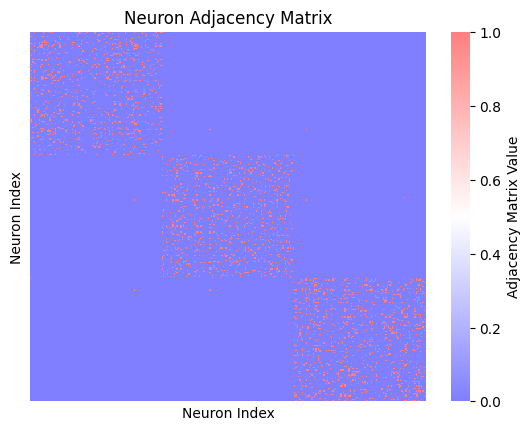



Network Configuration:


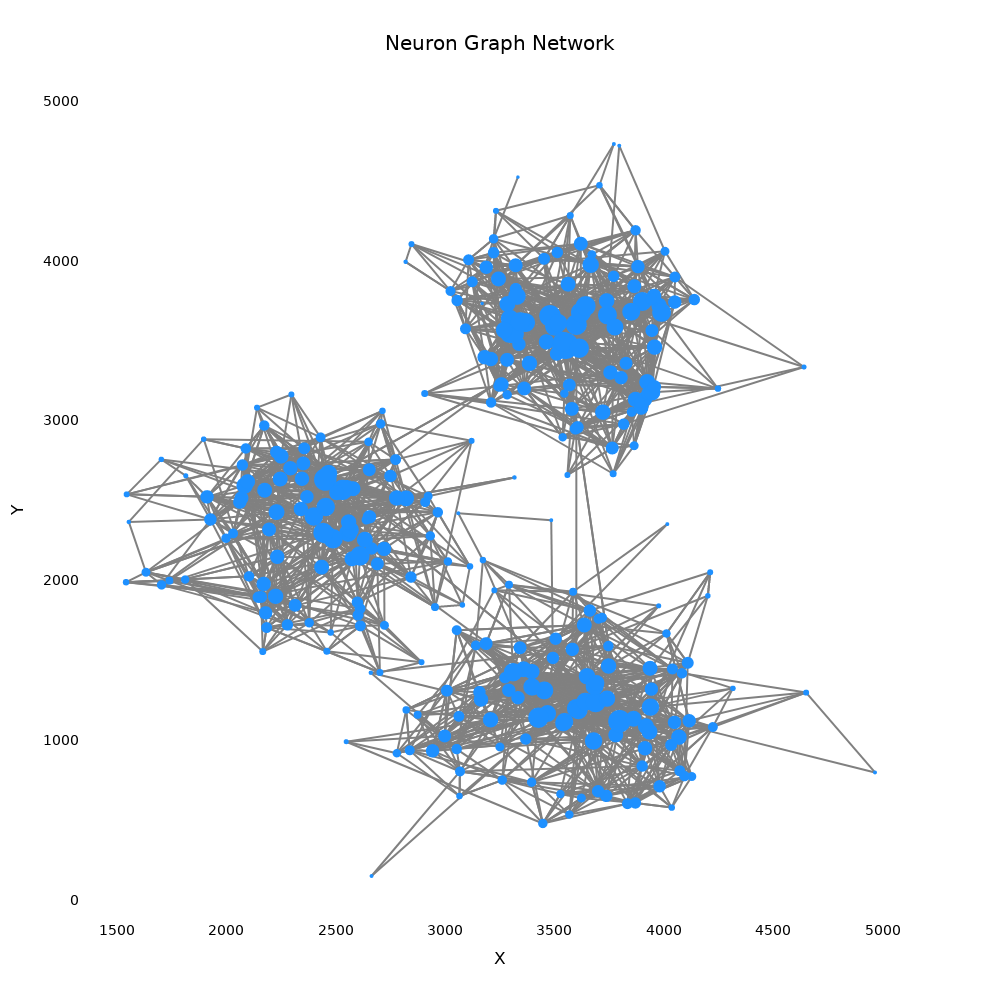

In [59]:
# Define the positions array
pos_array = GeneratePosArray(
        implement_nueron_modules_positions,
        n_dim = n_dim,
        radius = radius,
        n = n,
        num_groups = num_groups,
        n_per_group = n_per_group,
        seed = seed,
        std = module_std,
        x1_mean = x1_mean, 
        x2_mean = x2_mean,
        x3_mean = x3_mean,
        y1_mean = y1_mean,
        y2_mean = y2_mean,
        y3_mean = y3_mean, 
)

n = pos_array.shape[0]

# Calculate the euclidean distance between all nodes
distance_matrix = GetDistanceMatrix(
    pos_array = pos_array,
    n_dim = n_dim,
    check_symmetry = check_distance_matrix_symmetry
)

# Define the adjacency matrix and edges of the network
A, edges, rich_club_neurons = GetAdjacencyMatrix(
    implement_neuron_modules_connections = implement_neuron_modules_connections,
    distance_matrix = distance_matrix,
    pos_array = pos_array,
    radius = radius,
    n_dim = n_dim,
    adjacency_matrix_path = adjacency_matrix_path,
    network_graph_path = network_graph_path,
    n_per_group = n_per_group,
    num_groups = num_groups,
    distance_connection_probability_exponent_constant = distance_connection_probability_exponent_constant_for_modules,
    num_rich_club_neurons_per_module = num_rich_club_neurons_per_module,
    visualize_adjacency_matrix = visualize_adjacency_matrix,
    visualize_connected_network = visualize_connected_network,
    constant_connection_probability = constant_connection_probability
)

# The logic from inside of the FullSimulation code, just need it in Global Space for this portion
if implement_timing:
    # Find axons that should be myelinated if constant diameter
    myelinated_index = np.zeros(edges.shape[0])

    # Myelinated the signals between modules
    if implement_neuron_modules_connections:
        mod_1_to_2 = np.argwhere(np.logical_and(edges[:,0] == 0, edges[:, 1] == n_per_group)).flatten()
        mod_2_to_3 = np.argwhere(np.logical_and(edges[:,0] == n_per_group, edges[:, 1] == n_per_group*2)).flatten()
        mode_3_to_2 = np.argwhere(np.logical_and(edges[:,0] == n_per_group*3, edges[:, 1] == 0)).flatten()

        myelinated_index[mod_1_to_2] = 1
        myelinated_index[mod_2_to_3] = 1
        myelinated_index[mode_3_to_2] = 1
    
    time_to_complete_ap = PosArray_to_SignalTiming(
        pos_array, edges, config_dict, 
        constant_diameter, myelinated_index
    )
else:
    time_to_complete_ap = None

if implement_constant_weights:
    weight_adjustement = np.ones((n,n)) * constant_weight_value
    
else:
    weight_adjustement = np.random.normal(loc = mean_weight_val, scale = std_weight_val, size = (n,n))

    if weight_rich_club_connections_more:
        module_linking_neurons = np.array([0, n_per_group, n_per_group*2])
        weight_adjustement[module_linking_neurons, :] /= weight_adjustement[module_linking_neurons, :] # Set these all to 1 so that they have the maximum weight

In [62]:
### Create training data

# Define the number of time series to create
num_samples = 10
np.random.seed(seed) # Set the seed on the outside to have reproducible results
for experiment_id in range(num_samples):
    print(f'Current Experiment ID: {experiment_id}')
    constant_injected_current_index  = np.random.choice(
        np.arange(n), num_neurons_to_stimluate, 
        replace = False
    )
    out = SimulateNeurons(
        pos_array = pos_array,
        edges = edges,
        weights = A * weight_adjustement,
        num_time_steps = num_time_steps,
        time_to_complete_ap = time_to_complete_ap,
        q = q, # Random process added in
        constant_injected_current_index = constant_injected_current_index,
        vary_neuron_type = vary_neuron_type,
        resting_voltage = resting_voltage,
        default_a = default_a,
        default_b = default_b,
        default_c = default_c,
        default_d = default_d,
        superthreshold_injected_current = superthreshold_injected_current,
        highest_injected_current = highest_injected_current_for_modules,
        t_step_size = t_step_size,
        injected_current_decay_parameter = injected_current_decay_parameter,
        diagnostic_printing = diagnostic_printing,
        num_time_steps_with_injection = num_time_steps_with_injection
    )
    
    # Save the data
    np.savetxt(base_path + f'voltages/voltages-experiment-id-{experiment_id}.csv', out.voltages, delimiter = ',') # Voltages
    np.savetxt(base_path + f'spikes/spikes-experiment-id-{experiment_id}.csv', out.spikes, delimiter = ',') # Spikes
    np.savetxt(base_path + f'injected-current/injected-current-experiment-id-{experiment_id}.csv', out.injected_current, delimiter = ',') # Injected current
    np.savetxt(base_path + f'input-neurons/input-neurons-experiment-id-{experiment_id}.csv', constant_injected_current_index, delimiter = ',') # Input to the system, i.e. the neurons being stimulated

Current Experiment ID: 0
Current Experiment ID: 1
Current Experiment ID: 2
Current Experiment ID: 3
Current Experiment ID: 4
Current Experiment ID: 5
Current Experiment ID: 6
Current Experiment ID: 7
Current Experiment ID: 8
Current Experiment ID: 9


In [63]:
# Need a way to get the NamedTuple back
def CreateNamedTuple(
    voltages,
    t_step_size, # Make sure in ms
    num_time_steps
):
    SimulationResults = namedtuple(
        'SimulationResults', 
        [
            'voltages', 'us', 'injected_current',
            'spikes', 'q', 'num_time_steps', 't_step_size',
            't_index'
        ]
    )

    out = SimulationResults(
        voltages = voltages,
        us = None,
        injected_current = None,
        spikes = None,
        q = None,
        num_time_steps = num_time_steps,
        t_step_size = t_step_size,
        t_index = None
    )

    return out
    

Experiment ID: 0


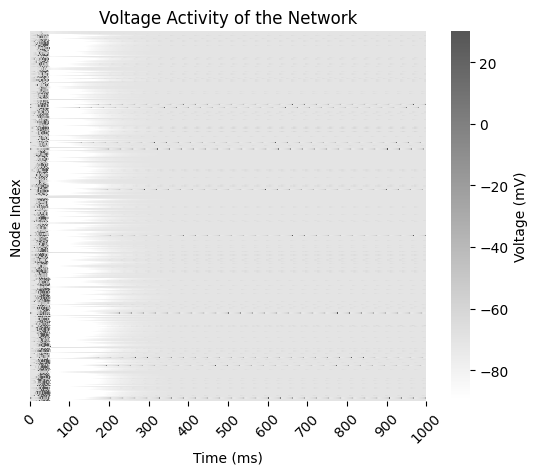

UnboundLocalError: cannot access local variable 'x_d' where it is not associated with a value

In [73]:
# Load in the data to see what it looks like and create the low dimensional data
voltages = []
input_neurons = []
pca_decompositions = []
num_dim_pca = 2 # Going to keep it with how it was above

for experiment_id in range(num_samples):
    print(f'Experiment ID: {experiment_id}')
    
    # Load in voltages and input neurons
    voltage_i = np.loadtxt(base_path + f'voltages/voltages-experiment-id-{experiment_id}.csv', delimiter = ',')
    inputs_i = np.loadtxt(base_path + f'input-neurons/input-neurons-experiment-id-{experiment_id}.csv', delimiter = ',')

    # Create the out object
    out = CreateNamedTuple(
        voltage_i, t_step_size * 1000, 
        num_time_steps
    )
    
    # Plot the voltage traces
    voltage_fig_path = base_path + f'figures/voltage-trace-experiment-id-{experiment_id}.png'
    PlotVoltageTrace(
        out, flip_axes=True, 
        include_node_indices=False, cmap = 'grey_r', 
        save_graphic_path=voltage_fig_path
    )  

    # Gather the PCA decomposition
    x_reduced, eig, eig_vecs = PCA(out, num_dim_pca, gaussian_filter_sigma, on_derivative = False)

    # Plot the PCA Over Time
    pca_trajectory_path = base_path + f'figures/pca-trajectory-non-derivatives-experiment-id-{experiment_id}.png'
    PCATrajectoryOverTime(x_reduced, num_time_steps, pca_trajectory_path)
    
    # Save in global space
    voltages += [voltage_i]
    input_neurons += [inputs_i]
    pca_decompositions += [x_reduced]

### Fitting the model

In [ ]:
# Analysis
import pysindy as ps

# For cross validation and splitting the time series
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
model = ps.SINDy()

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "optimizer__alpha": [0.01, 0.05, 0.1],
    "feature_library": [ps.PolynomialLibrary(), ps.FourierLibrary()],
    "differentiation_method__order": [1, 2]
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)

search.fit(x_reduced, t=t_step_size * 1000)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()